# CSCB Final Project 2024
#### Caleb Hallinan and Nicole Cheng
#### Deadline: May 13th 2024 9:00am

#### Import packages

In [1]:
# import packages
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import random
import os, sys
warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 300
sc.settings.set_figure_params(frameon=True, dpi=300)
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]
sc.logging.print_header()

# Set seed
random.seed(123)
np.random.seed(123)
import scFates as scf

import cellrank as cr
import scanpy as sc
import scvelo as scv

cr.settings.verbosity = 2
sc.settings.set_figure_params(frameon=False, dpi=100)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 300
sc.logging.print_header()

import numpy as np 
import pandas as pd 
import onesc 
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import os
import scanpy as sc
import anndata
import scipy as sp
import pySingleCellNet as pySCN
from joblib import dump, load
import sys
import igraph as ig
from igraph import Graph
ig.config['plotting.backend'] = 'matplotlib'


scanpy==1.9.8 anndata==0.10.5.post1 umap==0.5.5 numpy==1.26.4 scipy==1.11.4 pandas==1.5.3 scikit-learn==1.4.1.post1 statsmodels==0.14.1 igraph==0.11.4 pynndescent==0.5.11
scanpy==1.9.8 anndata==0.10.5.post1 umap==0.5.5 numpy==1.26.4 scipy==1.11.4 pandas==1.5.3 scikit-learn==1.4.1.post1 statsmodels==0.14.1 igraph==0.11.4 pynndescent==0.5.11


# Early data - all celltypes

In [2]:
# Load the data
adEarly = sc.read_h5ad("data/adEarly_CSCB24.h5ad")

# find mitochondrial genes and ribosomal genes
adEarly.var['mt'] = adEarly.var_names.str.startswith('MT-')
ribo_prefix = ("RPS","RPL")
adEarly.var['ribo'] = adEarly.var_names.str.startswith(ribo_prefix)
sc.pp.calculate_qc_metrics(adEarly, qc_vars=['mt','ribo'], percent_top=None, log1p=False, inplace=True)

# Now, do the filtering. First, keep only cells with < 20% mitochonrially encoded gene total UMIs
# adEarly = adEarly[adEarly.obs['pct_counts_mt']<20,:].copy()

# # Now filter based on total number of genes detected (at least 500) and total number of counts (less than 30,000). And keep genes that are detected in at least 3 cells.
# sc.pp.filter_cells(adEarly, min_genes=500)
# sc.pp.filter_cells(adEarly, max_counts=30000)
# sc.pp.filter_genes(adEarly, min_cells=3)

# Trim the data
# Remove rows with cell types that's less relavent in the early stage of adipocytes development in this dataset
adEarly = adEarly[~adEarly.obs['celltype'].isin(['Notocord','Ecto.Nascent.CN','Ecto.Neuro','Node','Ecto.Surface','Ecto.Neural_Crest','NMP','Primordial.GC','Anterior.PS','Endo.Gut', "Meso.Erythroid", 
                                                 "Meso.Endothelium", "Meso.HE_Prog", "Meso.Cardio", "Meso.LPM","Meso.Mesenchyme"])]
adEarly.obs.celltype

# ## Norm, HVG, PCA, kNN
sc.pp.normalize_total(adEarly , target_sum=1e4)
sc.pp.log1p(adEarly)
sc.pp.highly_variable_genes(adEarly , min_mean=0.0125, max_mean=6, min_disp=0.25)
sc.tl.pca(adEarly , use_highly_variable=True)

# # unspervised clustering
n_neighbors = 10
n_pcs = 15
sc.pp.neighbors(adEarly, n_neighbors=n_neighbors, n_pcs=n_pcs)
sc.tl.leiden(adEarly,.3)
sc.tl.paga(adEarly)
sc.pl.paga(adEarly, plot=False)
sc.tl.umap(adEarly, 0.2, init_pos='paga')

# # make unique
adEarly.var_names_make_unique()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


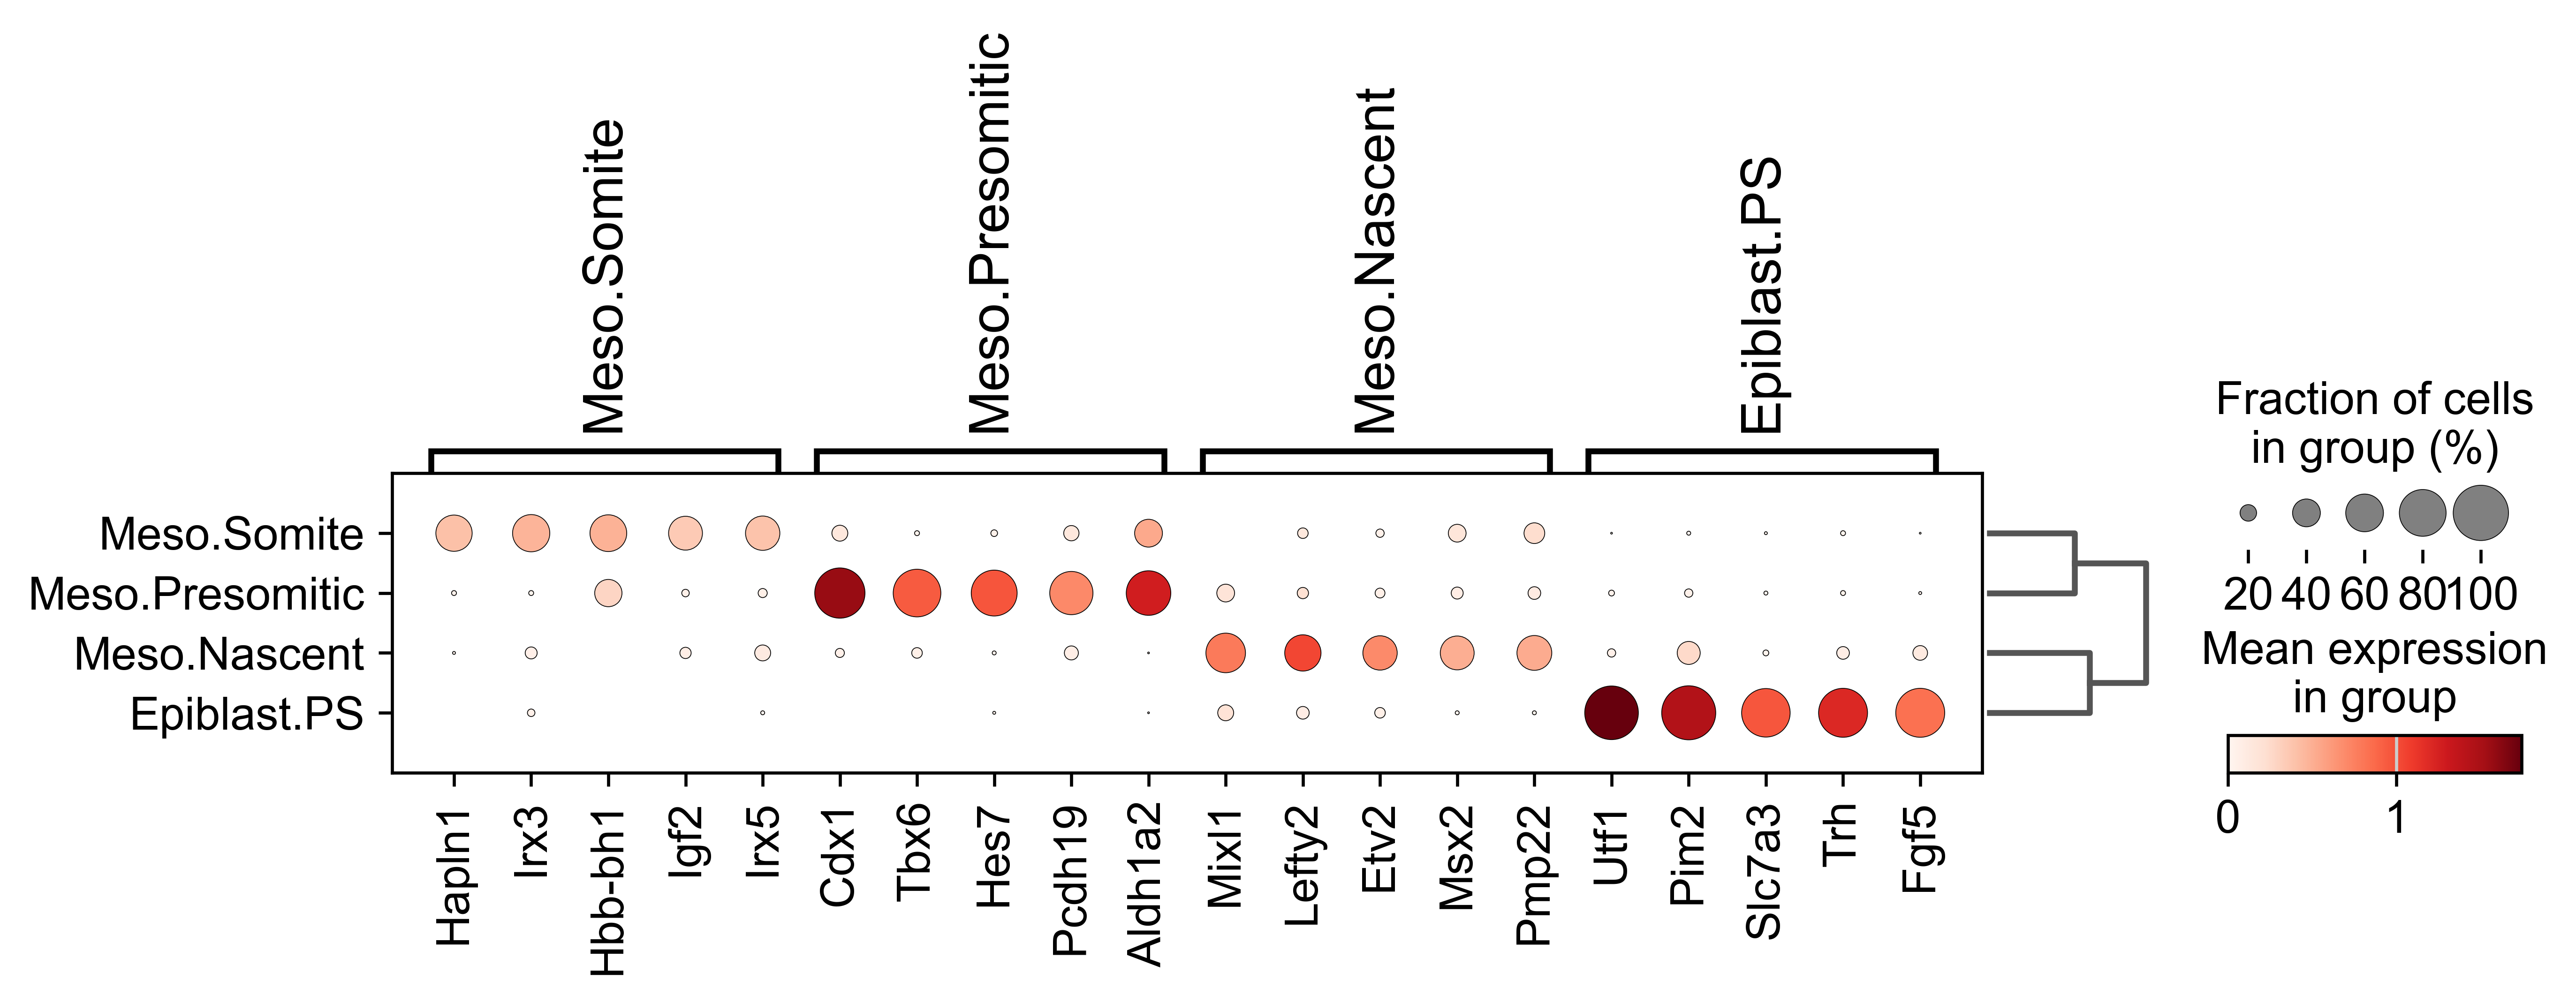

In [3]:
# Run differntial gene expression on clusters
# rank genes
sc.tl.rank_genes_groups(adEarly, use_raw=False, groupby="celltype", method='wilcoxon')

# plotting dotplot of top 5 genes for each cell type
sc.tl.filter_rank_genes_groups(adEarly, min_fold_change=.5, min_in_group_fraction=.15, max_out_group_fraction=.15)
sc.pl.rank_genes_groups_dotplot(adEarly, n_genes=5, groupby="celltype", dendrogram=True, key='rank_genes_groups_filtered')

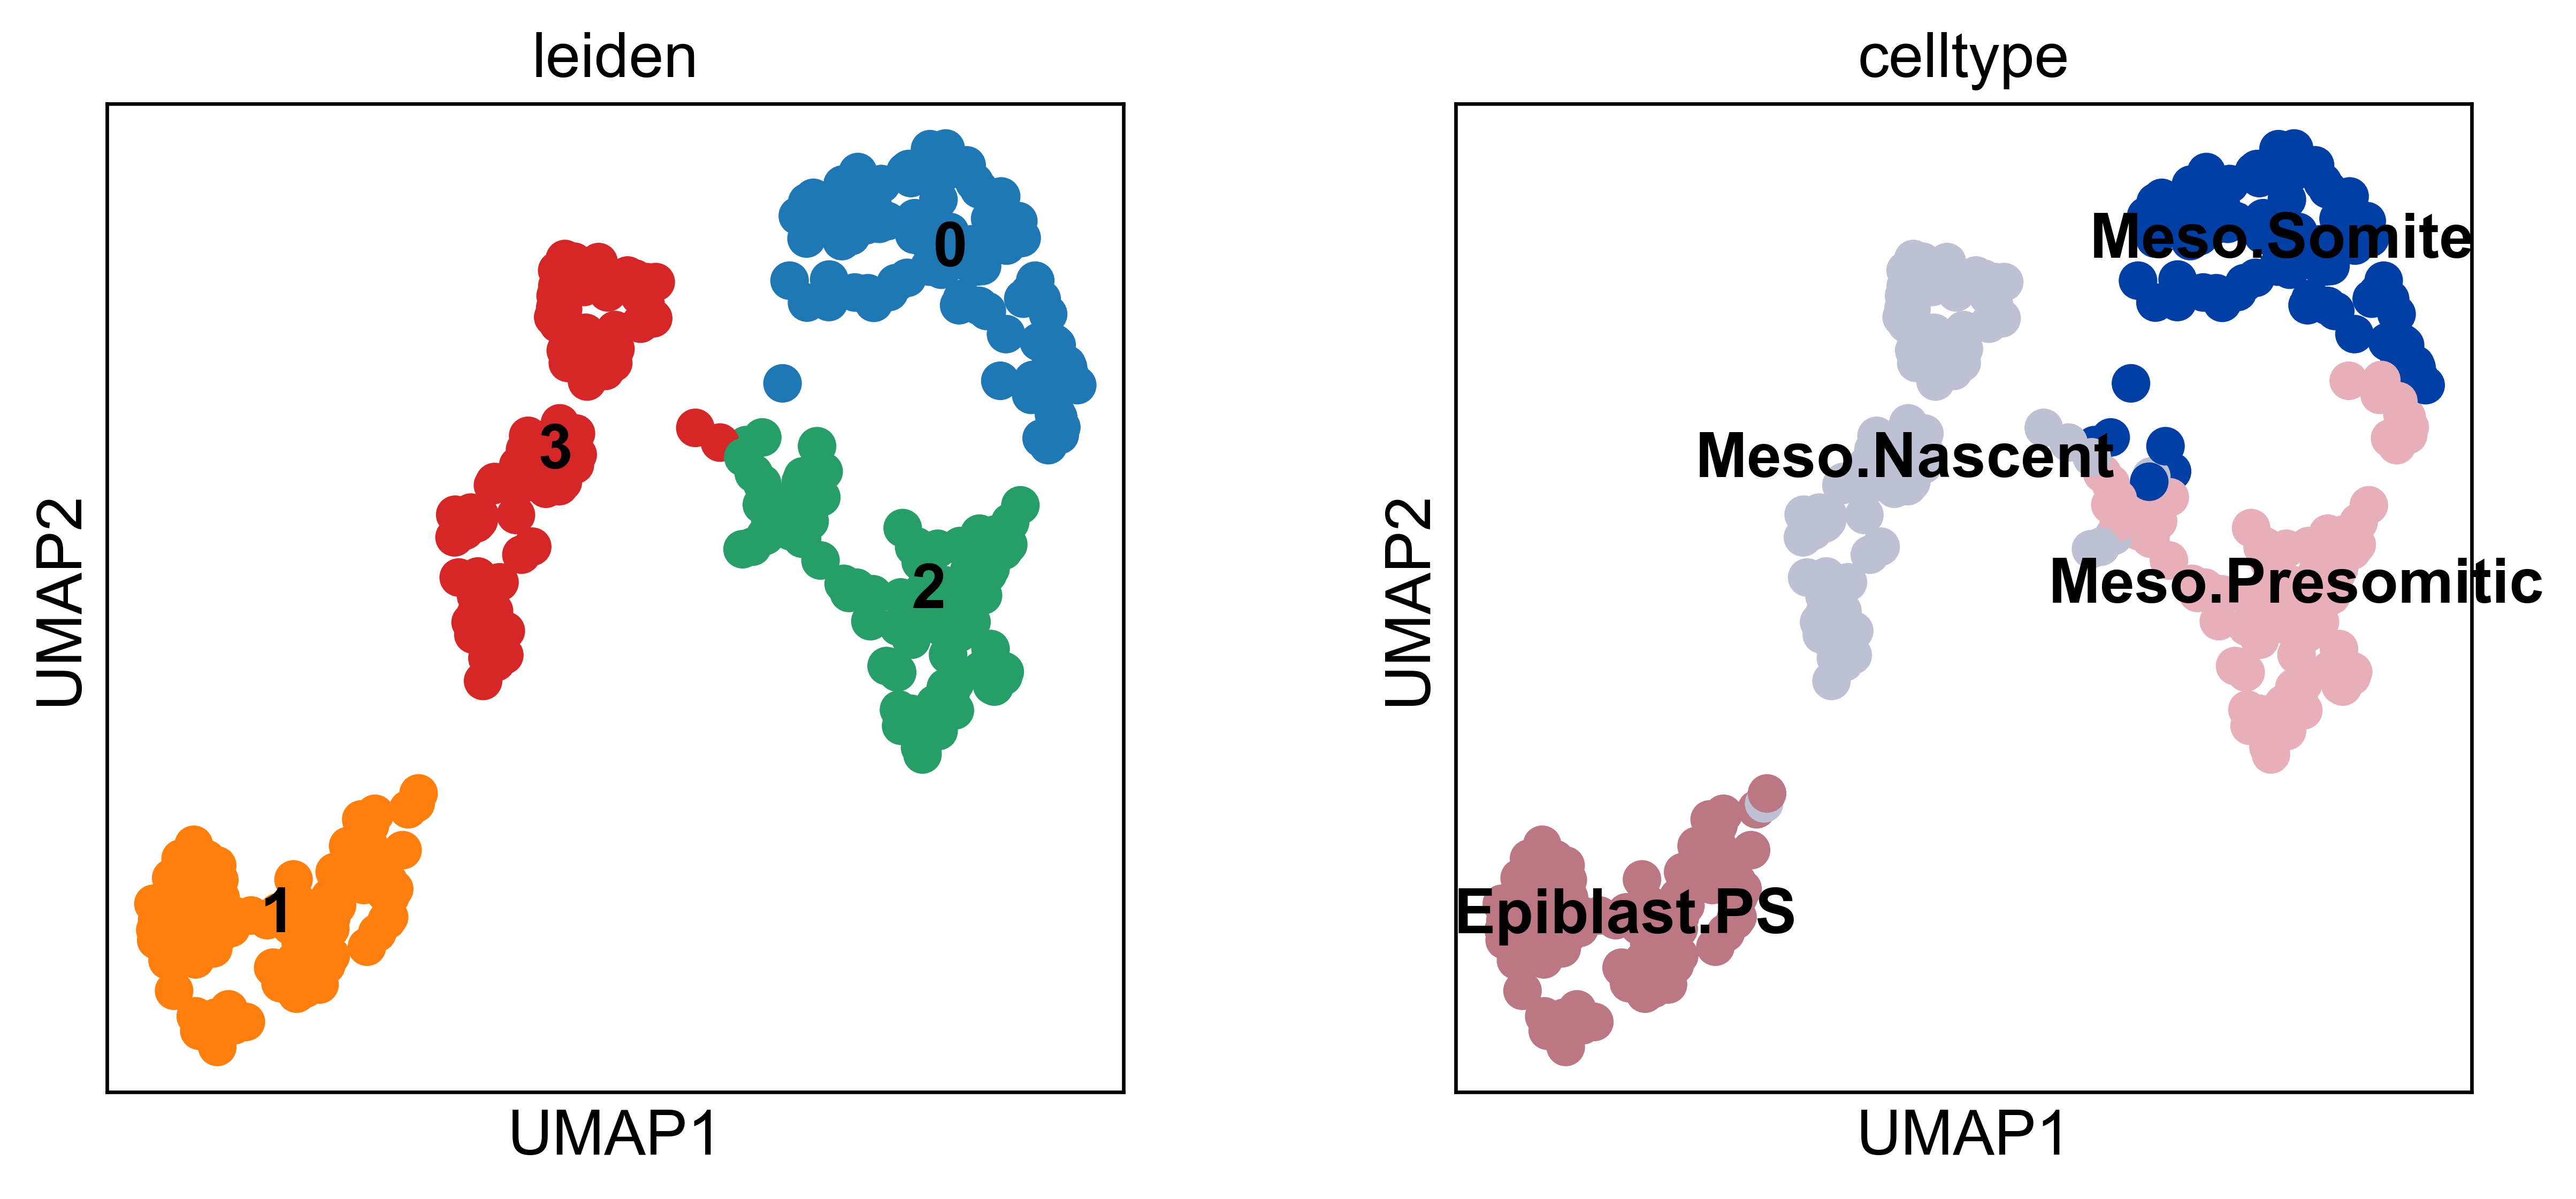

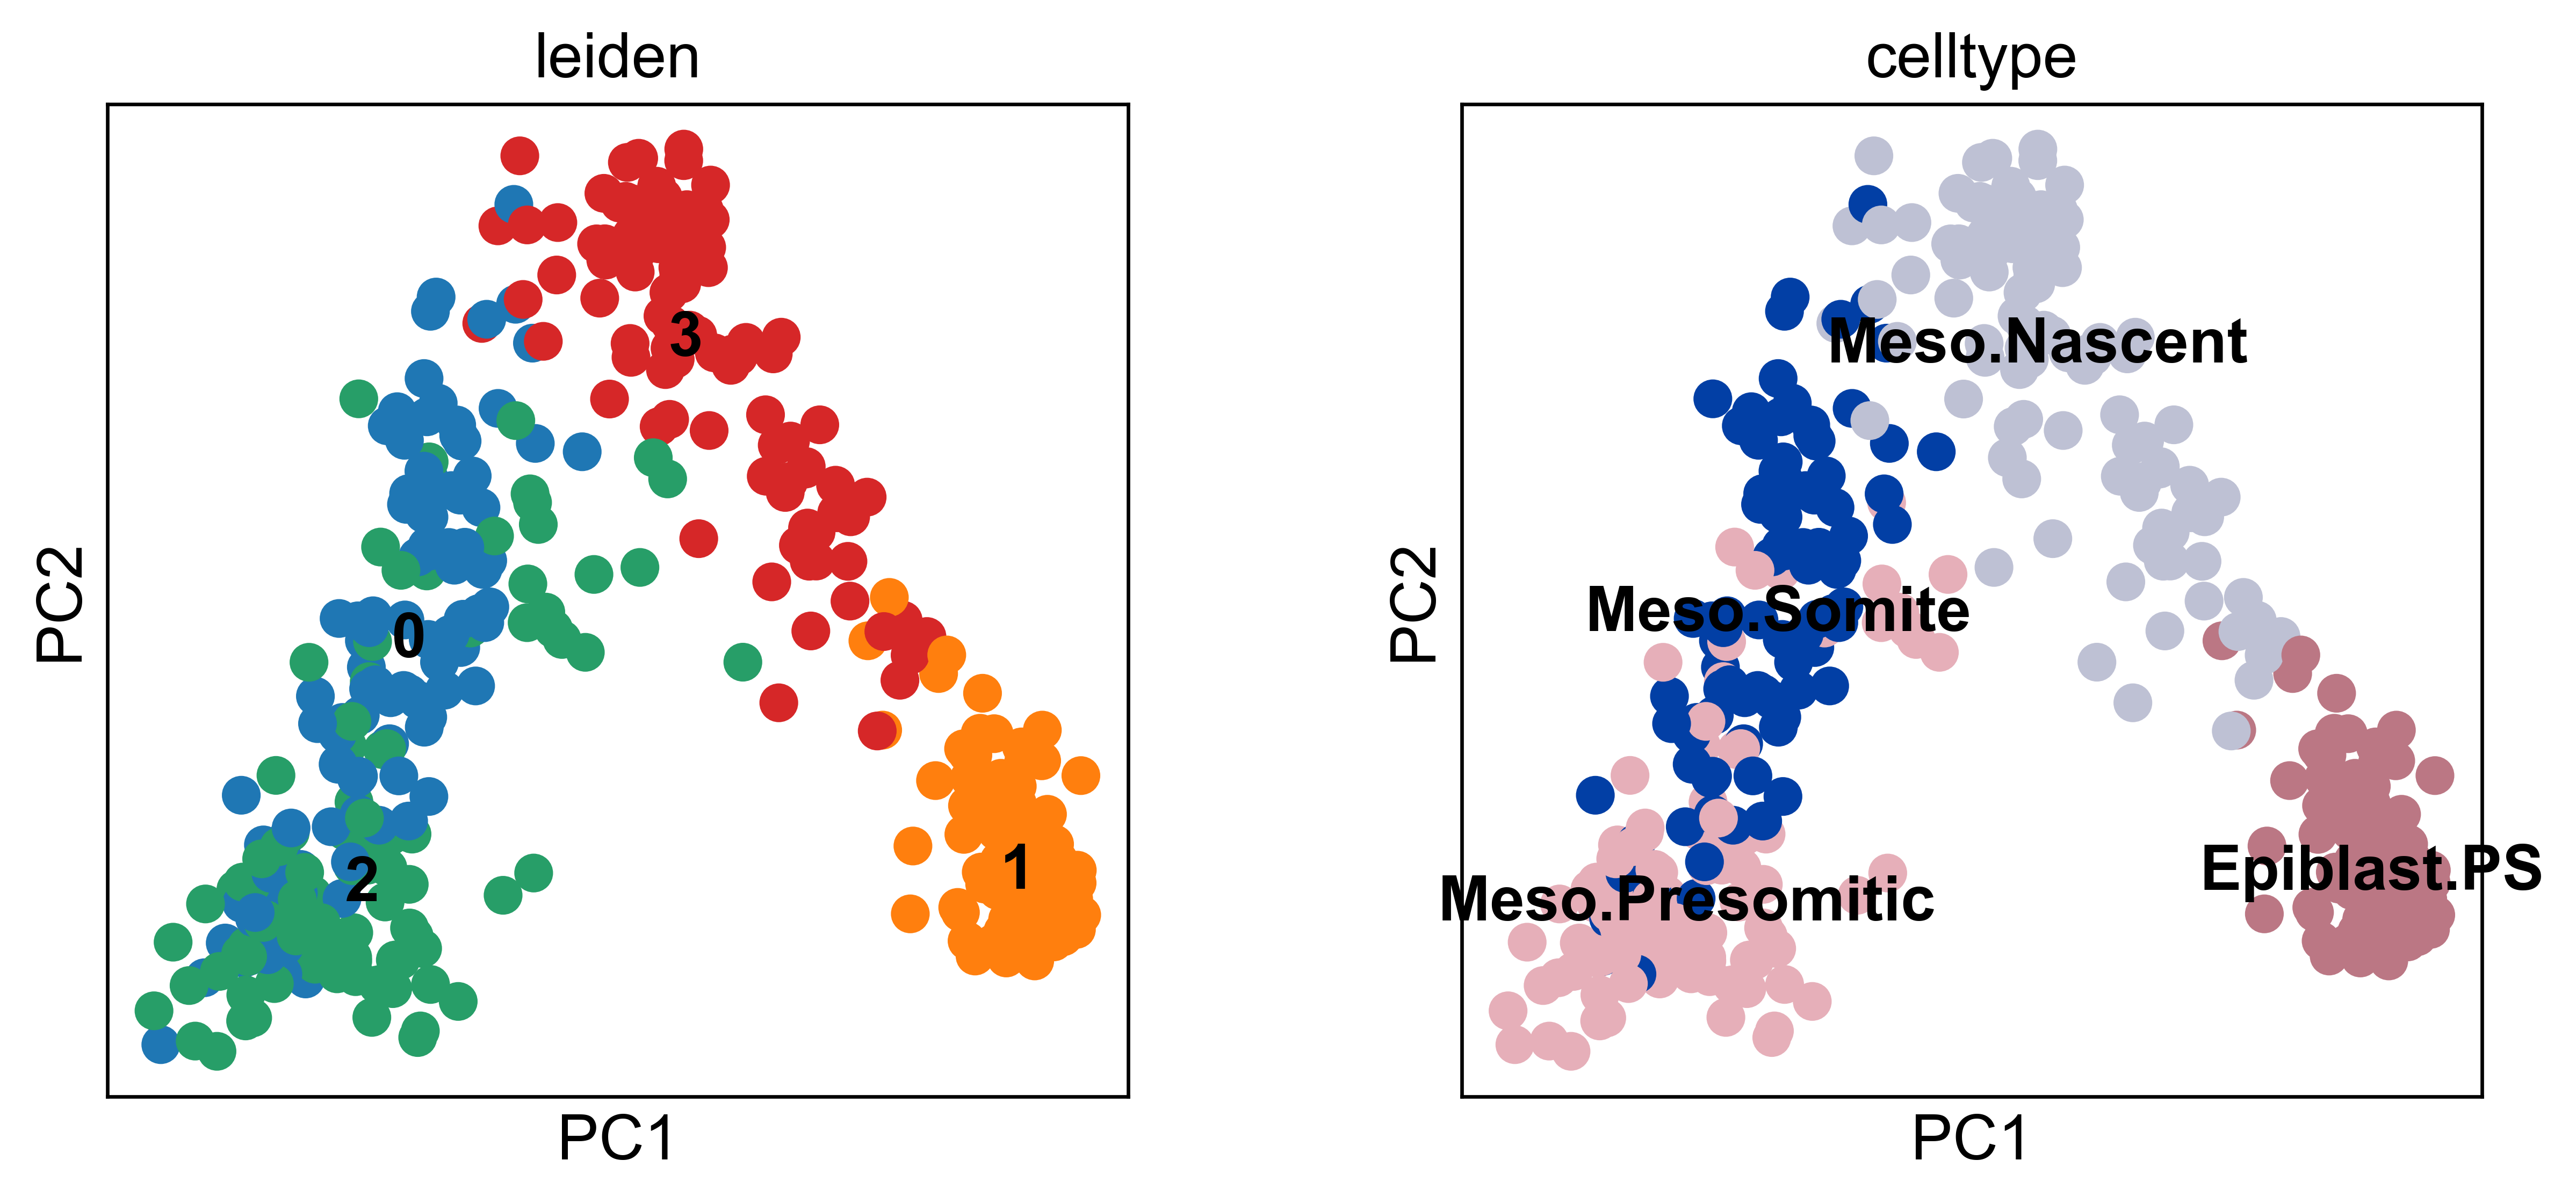

In [4]:
# plot umap and pca
sc.pl.umap(adEarly, color=['leiden', "celltype"], legend_loc='on data', title=['leiden'], frameon=True)
sc.pl.pca(adEarly, color=['leiden', "celltype"], legend_loc='on data', title=['leiden'], frameon=True)

In [5]:
# check the cell type distribution
pd.Series(adEarly.obs['celltype']).value_counts()

Meso.Somite        100
Meso.Nascent       100
Epiblast.PS        100
Meso.Presomitic    100
Name: celltype, dtype: int64

inferring a principal tree --> parameters used 
    5 principal points, sigma = 0.1, lambda = 1, metric = euclidean
    fitting:   0%|          | 3/1000 [00:00<02:45,  6.03it/s]
    converged
    finished (0:00:00) --> added 
    .uns['ppt'], dictionnary containing inferred tree.
    .obsm['X_R'] soft assignment of cells to principal points.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['F'] coordinates of principal points in representation space.


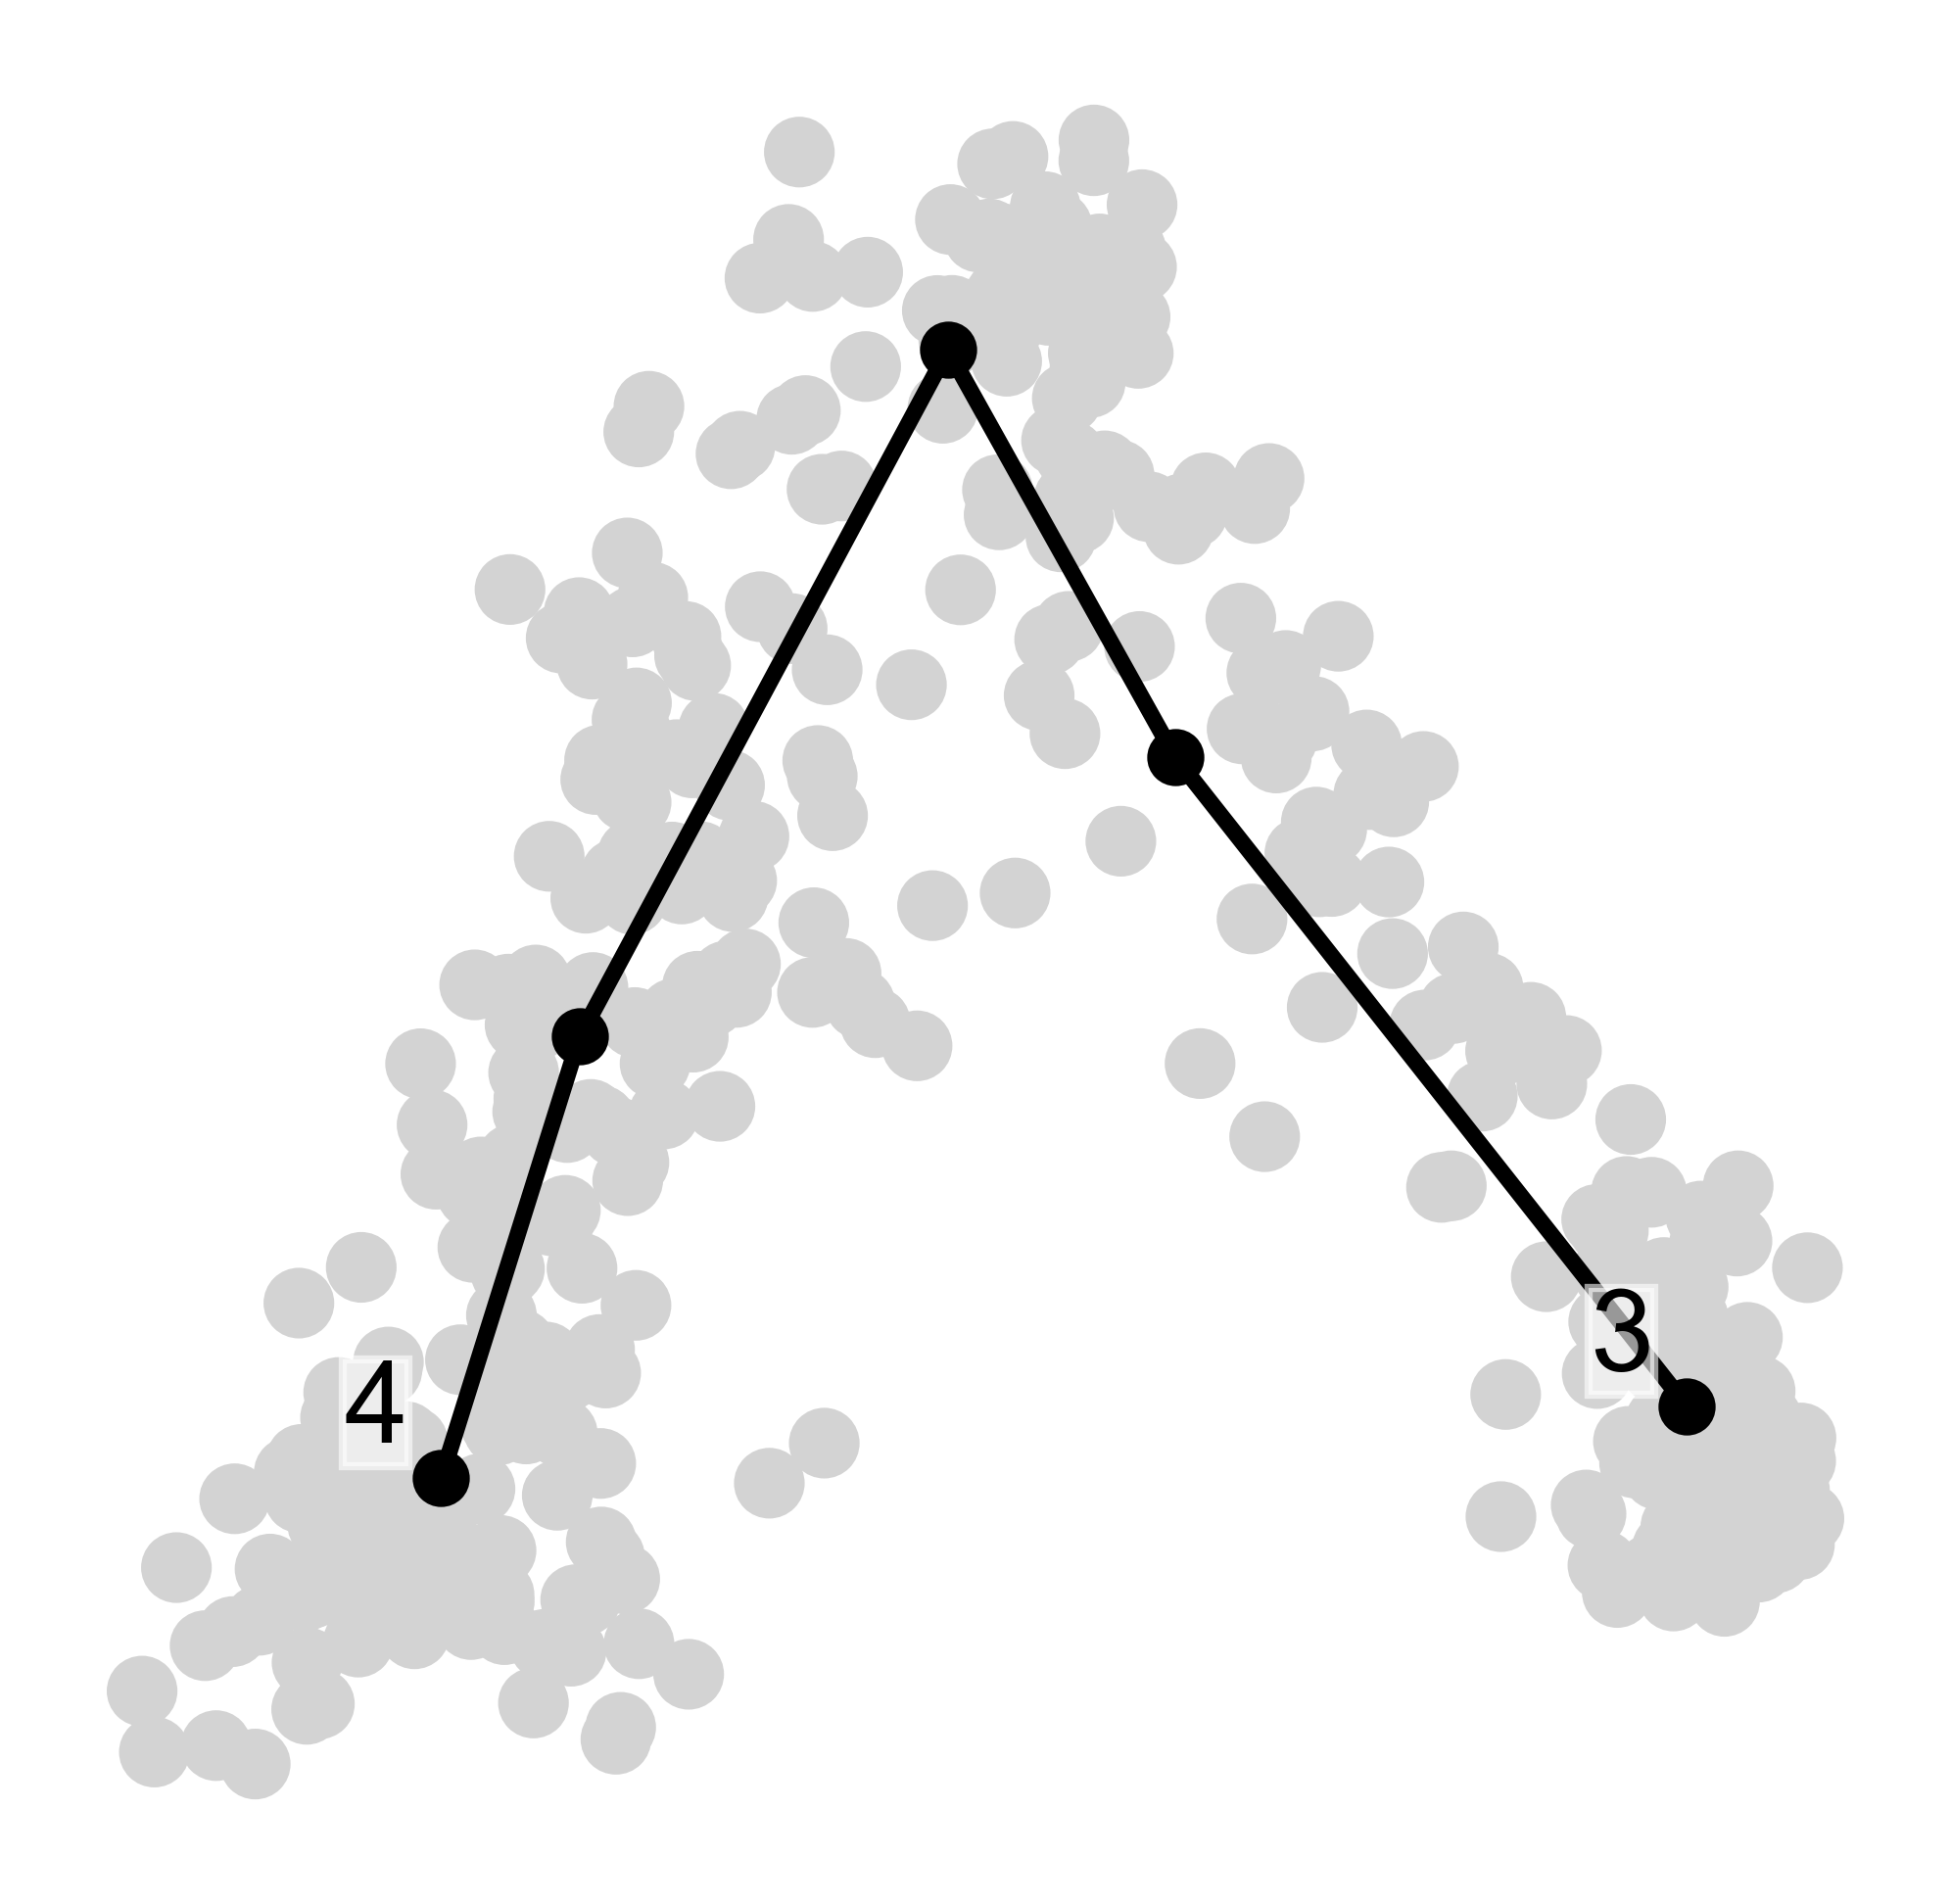

In [6]:
# Tree learning with SimplePPT using palantir embedding
scf.tl.tree(adEarly,method="ppt",Nodes=5,use_rep="pca",
            device="cpu",seed=1,ppt_lambda=1,ppt_sigma=0.1, ppt_nsteps=1000)

# plot the tree
scf.pl.graph(adEarly, basis='pca')

In [7]:
# know that 3 is start
scf.tl.root(adEarly,3)
# get pseudotime
scf.tl.pseudotime(adEarly,n_jobs=20,n_map=1,seed=42)

node 3 selected as a root --> added
    .uns['graph']['root'] selected root.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.
projecting cells onto the principal graph
    finished (0:00:00) --> added
    .obs['edge'] assigned edge.
    .obs['t'] pseudotime value.
    .obs['seg'] segment of the tree assigned.
    .obs['milestones'] milestone assigned.
    .uns['pseudotime_list'] list of cell projection from all mappings.


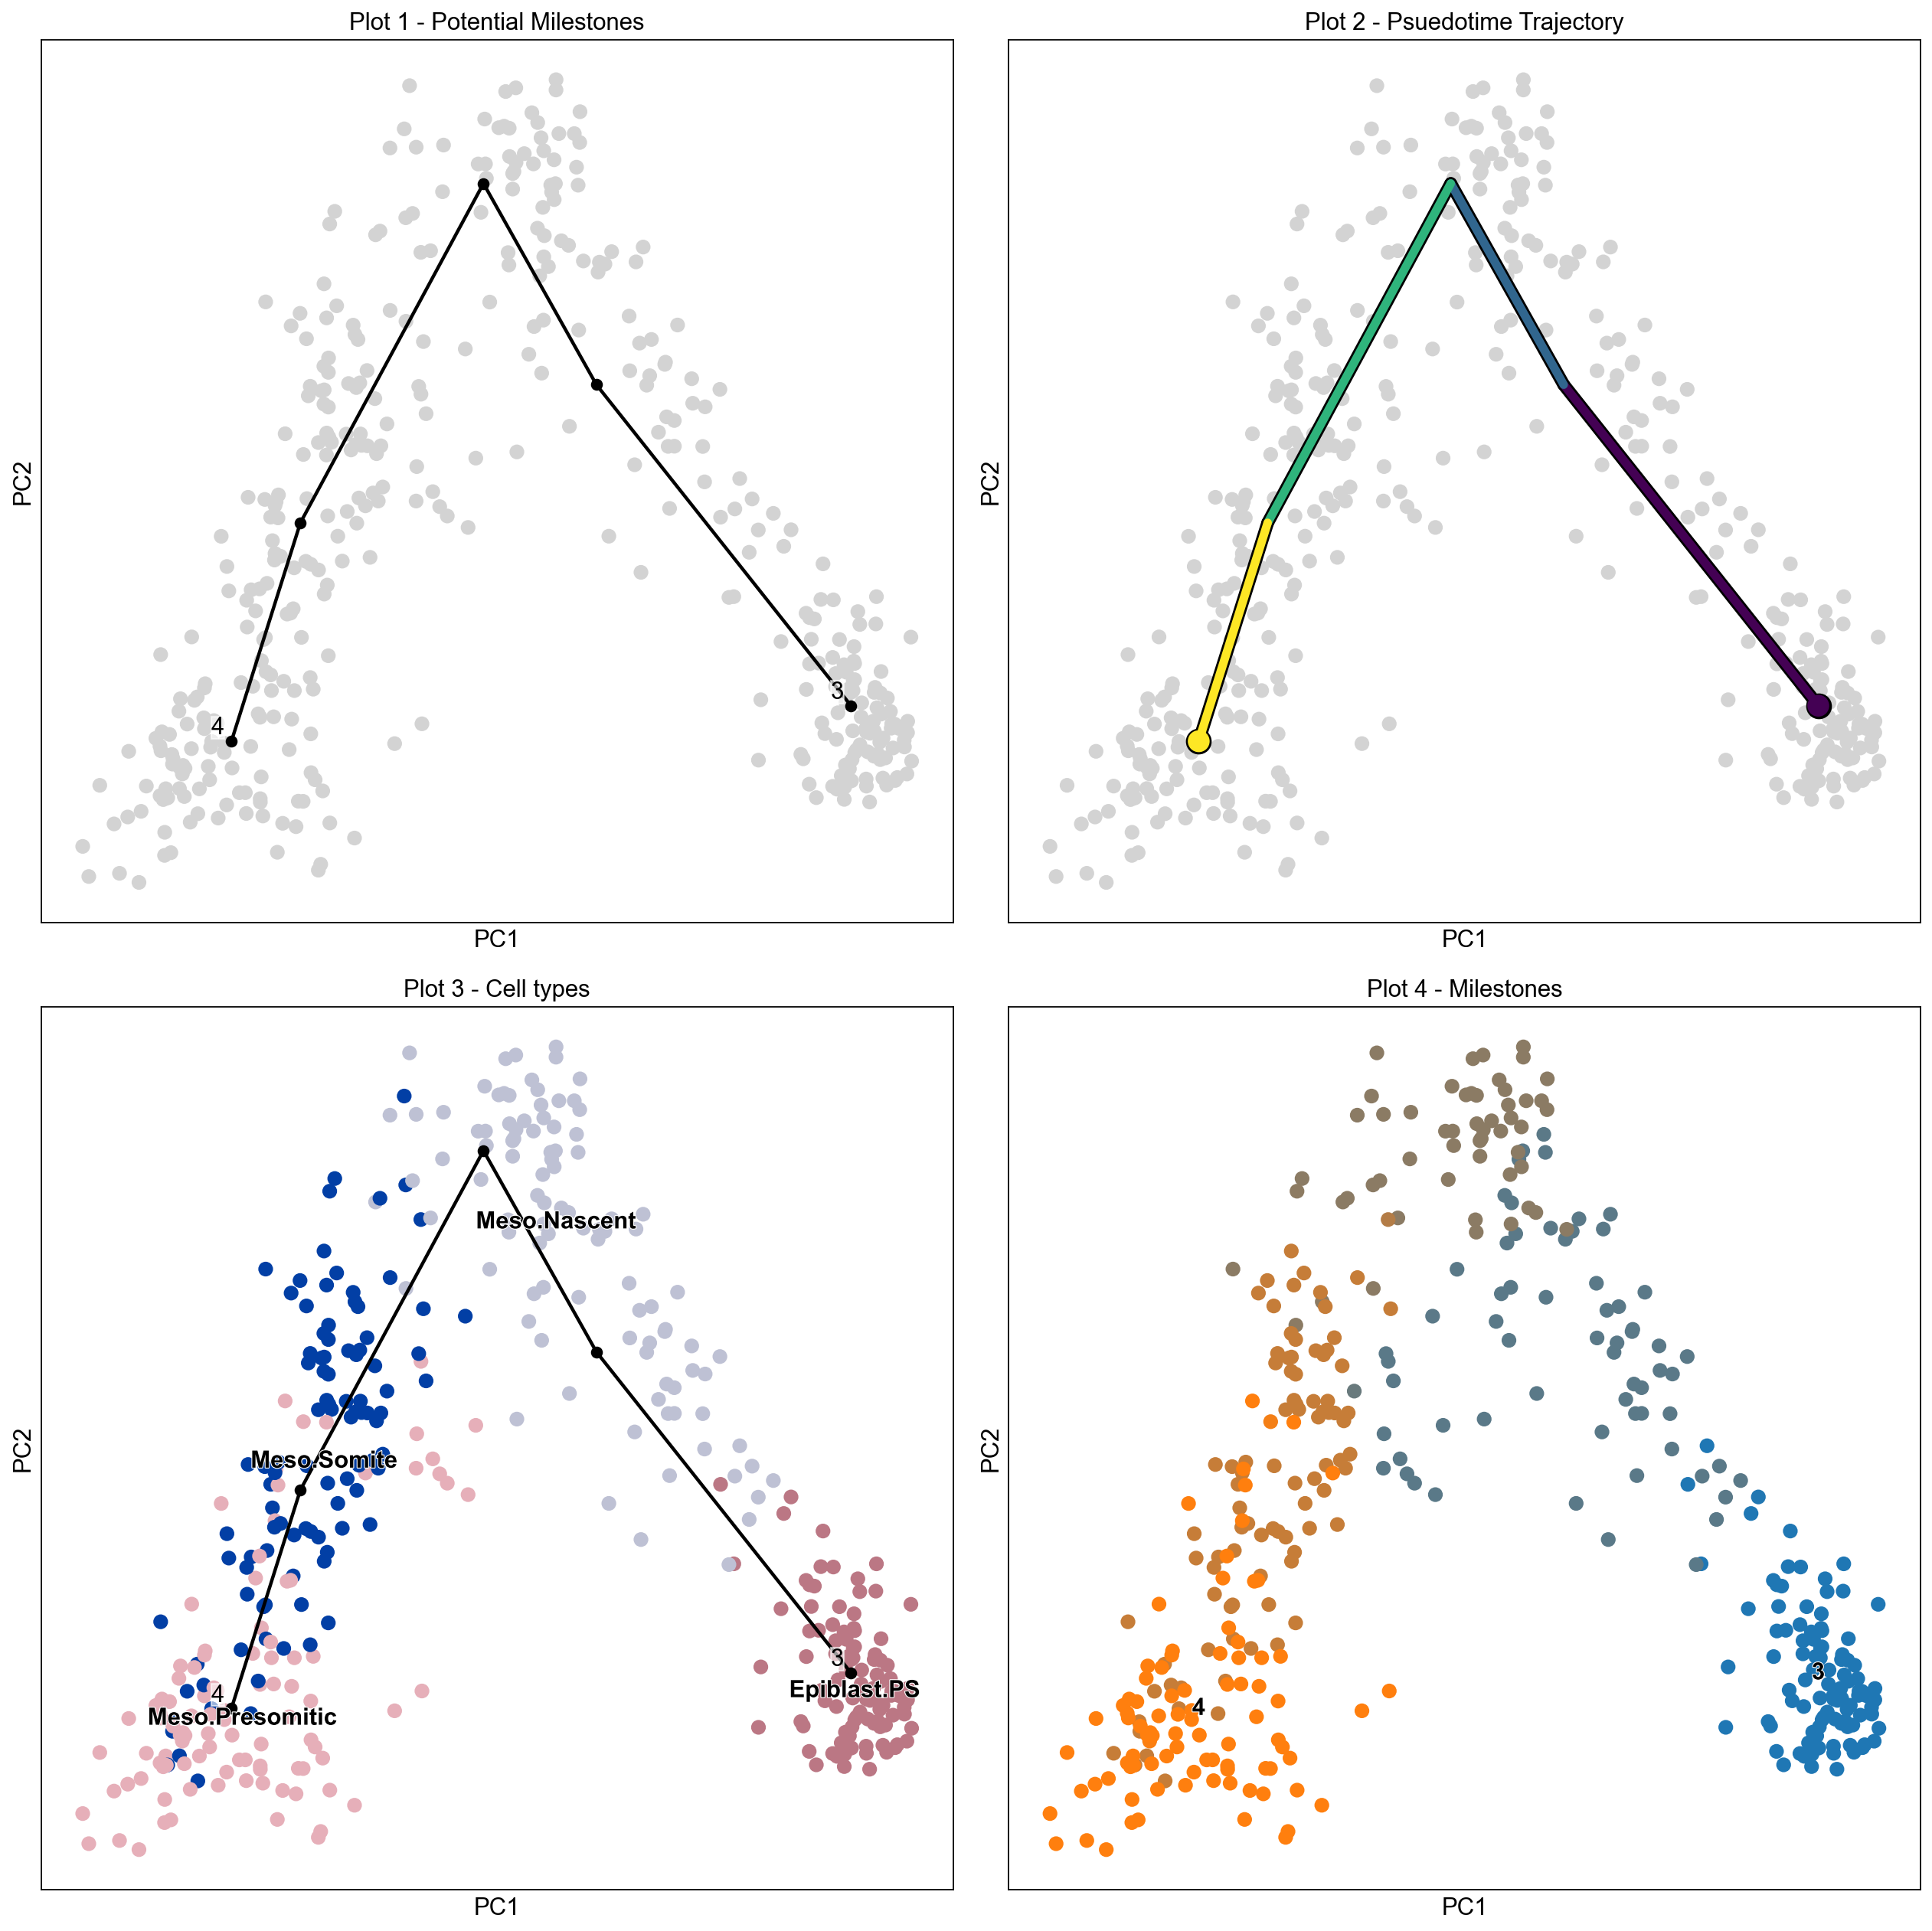

In [8]:
# set the method used
method_used = "pca"

# graph all required plots
sc.set_figure_params()
fig, axs=plt.subplots(2,2,figsize=(16,16))
axs=axs.ravel()
scf.pl.graph(adEarly,basis=method_used,show=False,ax=axs[0], title = "Plot 1 - Potential Milestones")
scf.pl.trajectory(adEarly,basis=method_used,show=False,ax=axs[1], title = "Plot 2 - Psuedotime Trajectory")
# scf.pl.graph(adEarly,color_cells=["seg"],legend_loc="on data",show=False,ax=axs[2],legend_fontoutline=True, basis=method_used, title = "Plot 3 - Cell types with segmented results")
scf.pl.graph(adEarly,color_cells=["celltype"],legend_loc="on data",show=False,ax=axs[2],legend_fontoutline=True, basis=method_used, title = "Plot 3 - Cell types")
scf.pl.milestones(adEarly,ax=axs[3],show=False,annotate=True, basis=method_used, title = "Plot 4 - Milestones")
plt.tight_layout()

Generating dendrogram of tree
    segment : 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]
    finished (0:00:00) --> added 
    .obsm['X_dendro'], new embedding generated.
    .uns['dendro_segments'] tree segments used for plotting.


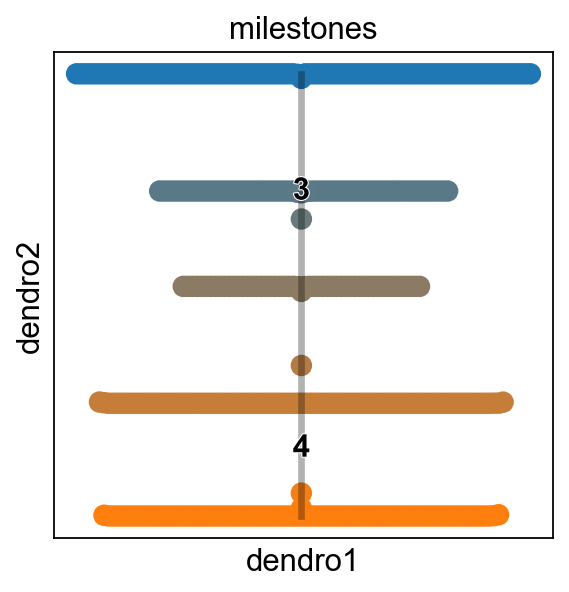

In [9]:
# Generate a single-cell dendrogram embedding.
scf.tl.dendrogram(adEarly)
scf.pl.dendrogram(adEarly,color="milestones",legend_loc="on data",color_milestones=True,legend_fontoutline=True)

test features for association with the trajectory
    single mapping : 100%|██████████| 29452/29452 [00:28<00:00, 1030.61it/s]
    found 191 significant features (0:00:28) --> added
    .var['p_val'] values from statistical test.
    .var['fdr'] corrected values from multiple testing.
    .var['st'] proportion of mapping in which feature is significant.
    .var['A'] amplitue of change of tested feature.
    .var['signi'] feature is significantly changing along pseudotime.
    .uns['stat_assoc_list'] list of fitted features on the graph for all mappings.


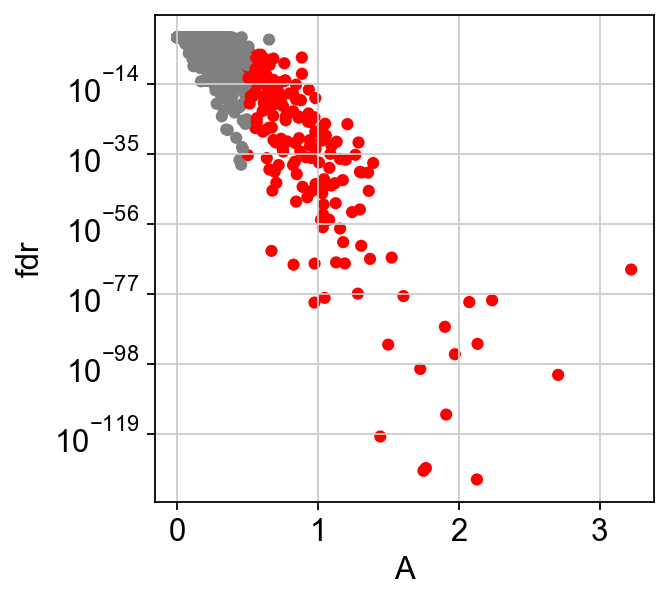

In [10]:
# Determine a set of genes significantly associated with the trajectory.
scf.tl.test_association(adEarly, fdr_cut=0.0001, A_cut=.5, n_jobs=20) # tried to make this lower but it didn't work
# plot
sc.set_figure_params()
scf.pl.test_association(adEarly)

In [11]:
# Model feature expression levels as a function of tree positions.
scf.tl.fit(adEarly,n_jobs=20)

fit features associated with the trajectory
    single mapping : 100%|██████████| 191/191 [00:00<00:00, 897.62it/s]
    finished (adata subsetted to keep only fitted features!) (0:00:00) --> added
    .layers['fitted'], fitted features on the trajectory for all mappings.
    .raw, unfiltered data.


Clustering features using fitted layer
    finished (0:00:01) --> added 
    .var['clusters'] identified modules.


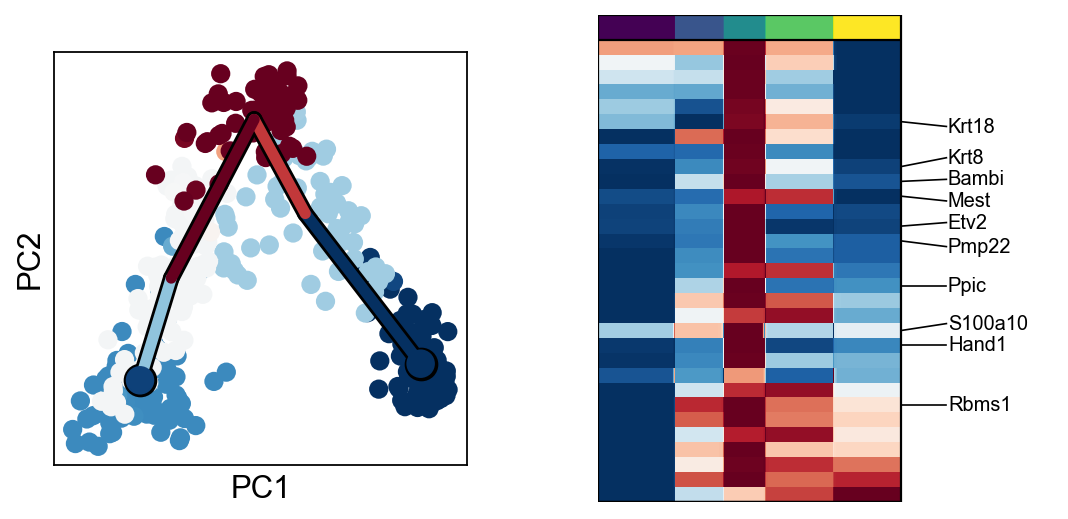

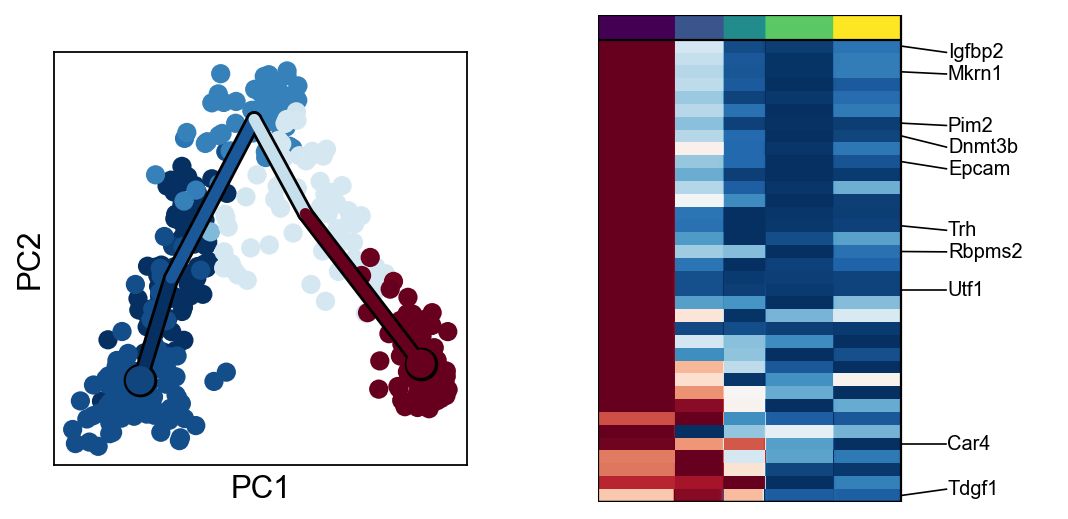

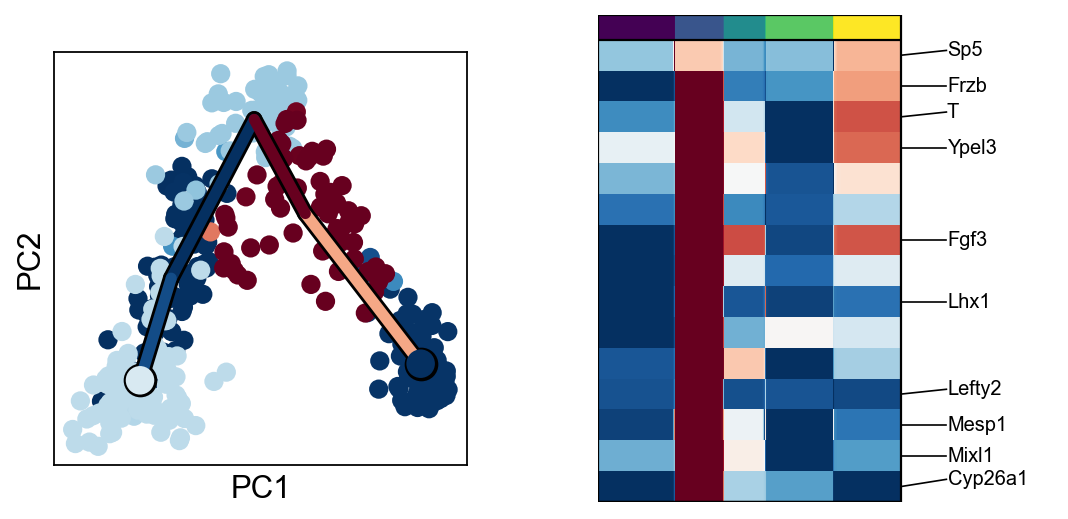

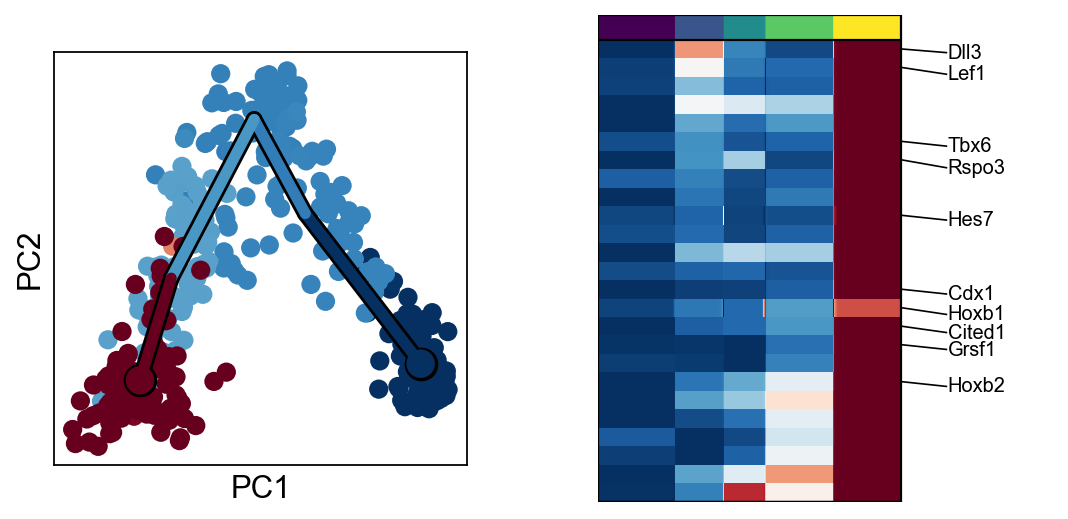

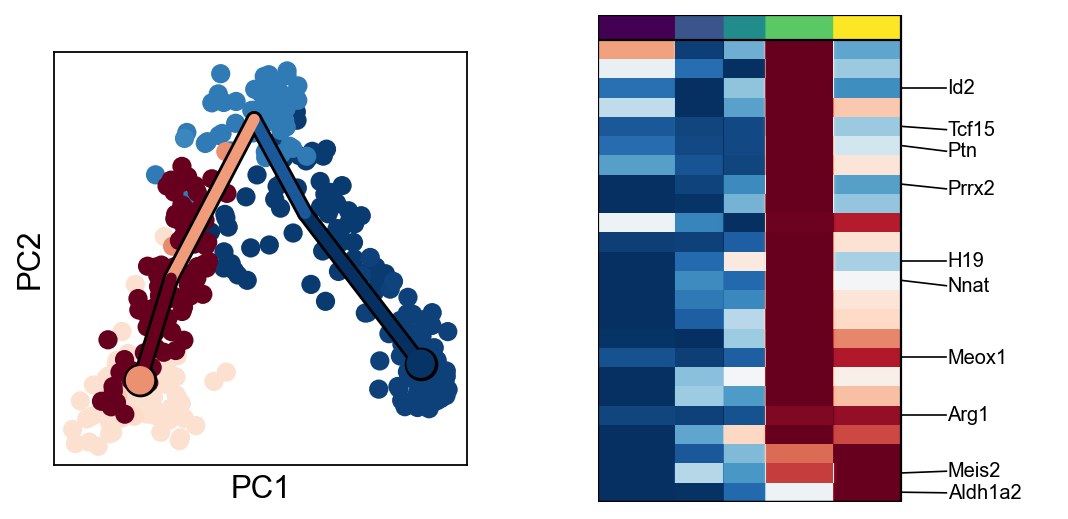

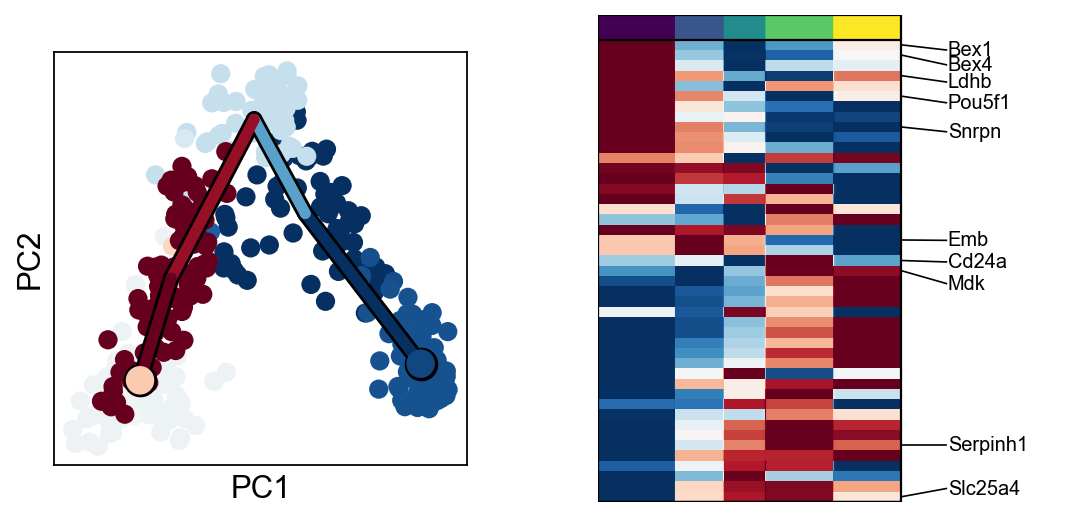

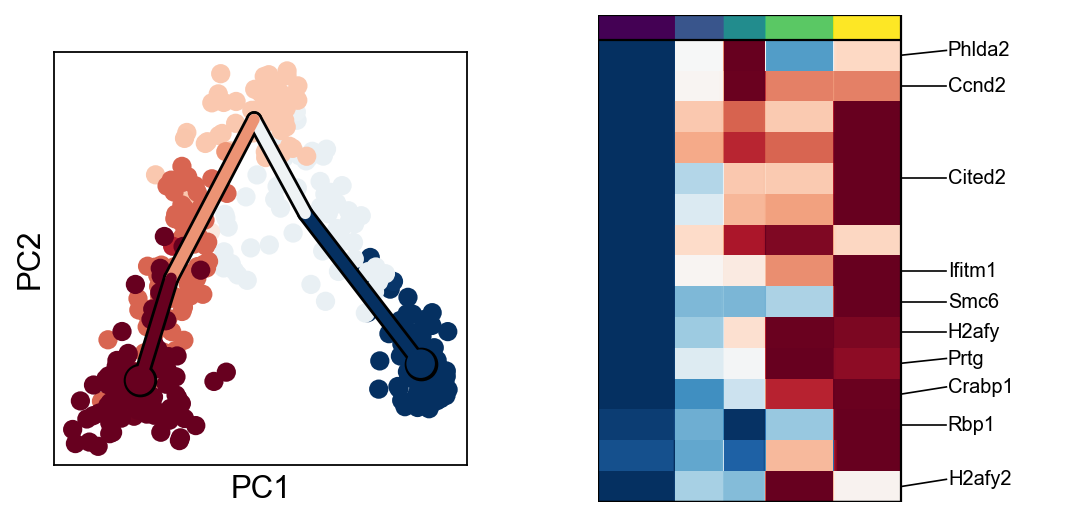

In [12]:
# cluster
scf.tl.cluster(adEarly,n_neighbors=20,metric="correlation")

# plot the clusters
adEarly.var.clusters.unique()
for c in adEarly.var["clusters"].unique():
    scf.pl.trends(adEarly,features=adEarly.var_names[adEarly.var.clusters==c],basis="pca")

In [13]:
# get all the tfs from clusters
tfs = []
for c in adEarly.var["clusters"].unique():
    tfs.append(list(adEarly.var_names[adEarly.var.clusters==c]))

# unpack the list of lists
tfs = [item for sublist in tfs for item in sublist]
tfs

['Fn1',
 'Rbms1',
 'Dusp9',
 'Pja1',
 'Spin2c',
 'S100a10',
 'Wls',
 'Msx1',
 'Kdr',
 'Mest',
 'Peg3',
 'Nectin2',
 'Etv2',
 'Cdkn1c',
 'Cnn2',
 'Phlda1',
 'Foxf1',
 'Myl7',
 'Sparc',
 'Hand1',
 'Pmp22',
 'Tmem88',
 'Tax1bp3',
 'Igfbp4',
 'Msx2',
 'Krt8',
 'Krt18',
 'Hes1',
 'Clic1',
 'Bambi',
 'Ppic',
 'Igfbp2',
 'Dnmt3b',
 'Wfdc2',
 'Pim2',
 'Slc7a3',
 'Tpd52',
 'Car2',
 'Acer2',
 'Pou3f1',
 'Fgf5',
 'Mkrn1',
 'Trh',
 'Spint2',
 'Utf1',
 'Chchd10',
 'Socs2',
 'Rbpms',
 'Isyna1',
 'Syce2',
 'Nefl',
 'Rbpms2',
 'Dppa5a',
 'Tdgf1',
 'Eomes',
 'Cldn7',
 'Car4',
 'Meg3',
 'Crip2',
 'Cldn6',
 'Tgif1',
 'Epcam',
 'Pmaip1',
 'Rasgrp2',
 'Gng3',
 'Stx3',
 'Fgf8',
 'Mixl1',
 'Lefty2',
 'Sp5',
 'Frzb',
 'Snai1',
 'Efna3',
 'Agtrap',
 'Mesp1',
 'Mesp2',
 'Ypel3',
 'Fgf3',
 'Lhx1',
 'Gas1',
 'T',
 'Cyp26a1',
 'Vim',
 'Cited1',
 'Pcdh19',
 'Car3',
 'Anxa5',
 'Crabp2',
 'Lef1',
 'Grsf1',
 'Cdx2',
 'Hoxa1',
 'Hoxaas3',
 'Dll3',
 'Tbx6',
 'Rspo3',
 'Fabp7',
 'Fam212a',
 'Pdlim4',
 'Hes7',
 'Hoxb3os',

In [14]:
# check if a tf is in the list for lit review
my_list = list(adEarly.var.index)
my_string = 'Pax3'

if my_string in my_list:
    print(my_string + " is present in the list")
else:
    print(my_string + " is not present in the list")


Pax3 is not present in the list


In [15]:
# read in transcription factors
allTFs = pd.read_csv("/Users/calebhallinan/Desktop/jhu/classes/computational_stem_cell_biology/homeworks/hw3/data/allTFs_mm_aertslab_011924.txt", header = None)
# make a list
allTFs = allTFs[0].tolist()

# get intersection of transcription factors with high A value
intersection = list(set(allTFs) & set(adEarly.var[adEarly.var["A"] > 1].index.tolist()))
# intersection = list(set(allTFs) & set(tfs))
intersection

# lit review list along with TFs above A value threshold
# intersection = [
#     'Eomes',
#     'T',
#     'Snai1',
#     'Tbx6',
#     'Mesp2',
#     'Mesp1',
#     'Meox1',
#     'Lhx1',
#     "Pou5f1",
#     "Lef1",
# ]

['Pou5f1',
 'Hes7',
 'Prrx2',
 'Id2',
 'Lef1',
 'Hand1',
 'Cdx1',
 'Tbx6',
 'Etv2',
 'Phlda2',
 'Hoxb2',
 'Hoxb1',
 'H2afy',
 'T',
 'Arg1',
 'Mesp1',
 'Tcf15',
 'Hmga2']

Computing CytoTRACE score with `191` genes. Consider using more than `10000` genes
Adding `adata.obs['ct_score']`
       `adata.obs['ct_pseudotime']`
       `adata.obs['ct_num_exp_genes']`
       `adata.var['ct_gene_corr']`
       `adata.var['ct_correlates']`
       `adata.uns['ct_params']`
    Finish (0:00:00)


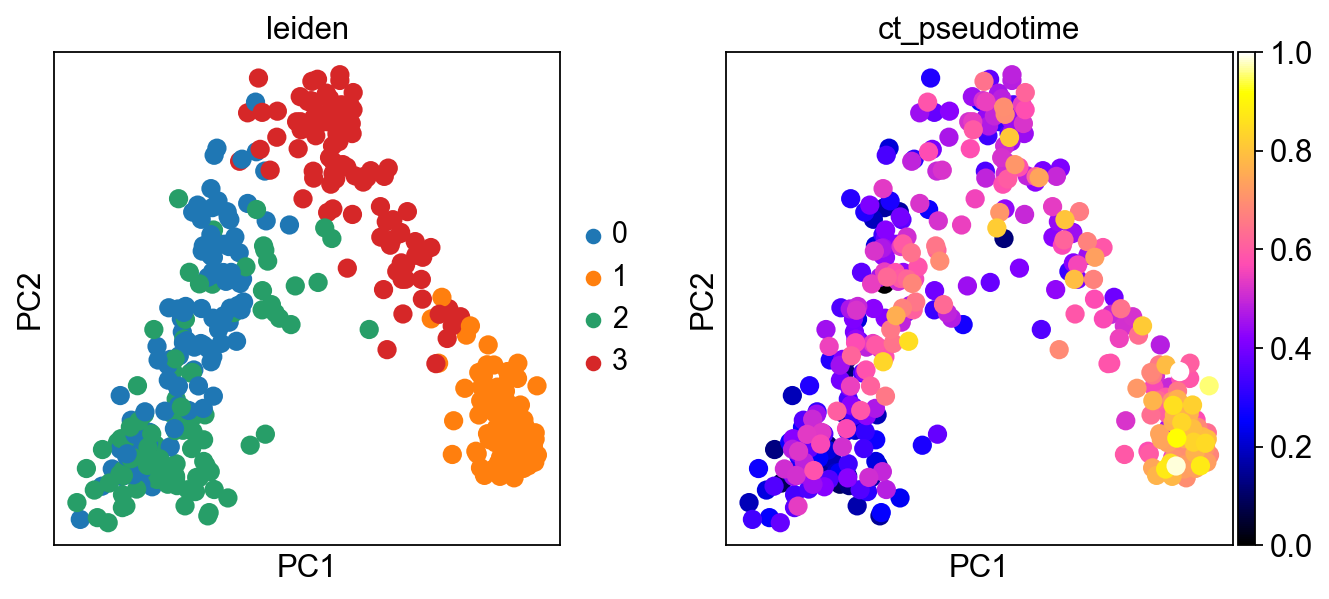

In [16]:
# import packages
import cellrank as cr
import scanpy as sc
import scvelo as scv
from cellrank.kernels import CytoTRACEKernel

# run cytotrace for pseudotime
# set verbosity
cr.settings.verbosity = 2

# calculate pseudotime
ctk = CytoTRACEKernel(adEarly).compute_cytotrace(layer = "X", n_genes=1000)

# plot pseudotime
sc.pl.embedding(
    adEarly,
    color=["leiden", "ct_pseudotime"],
    basis="pca",
    color_map="gnuplot2"
)

Epiblast.PS : 
100
Meso.Nascent : 
100
Meso.Presomitic : 
100
Meso.Somite : 
100


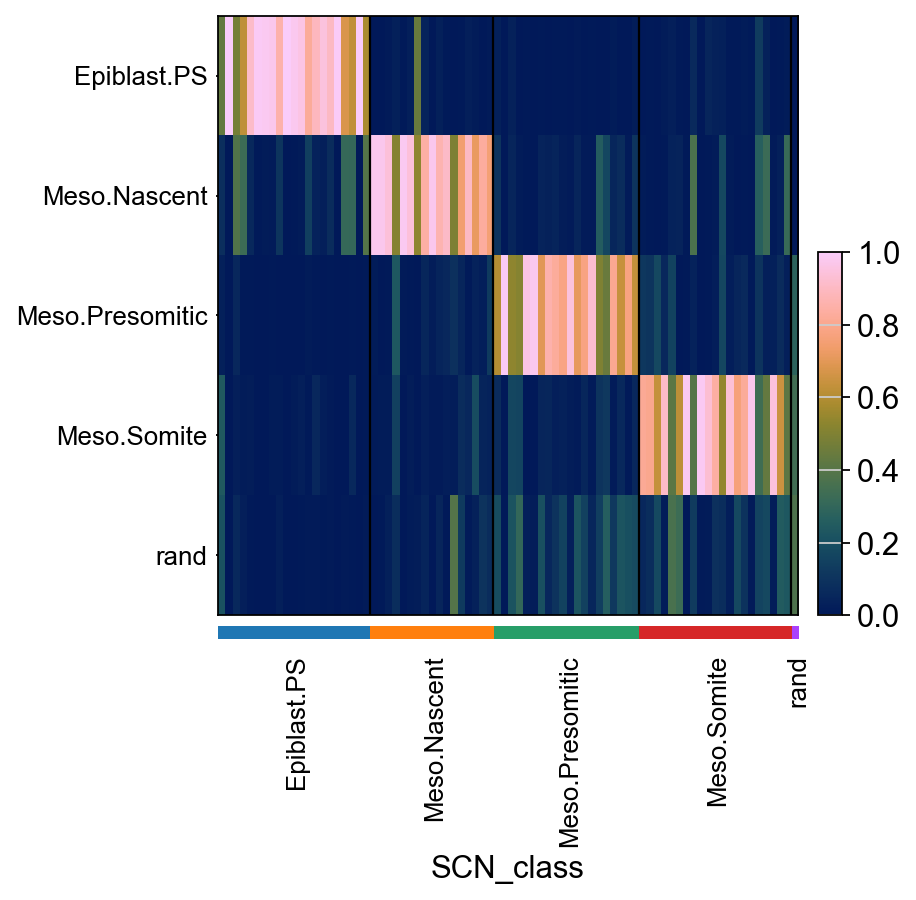

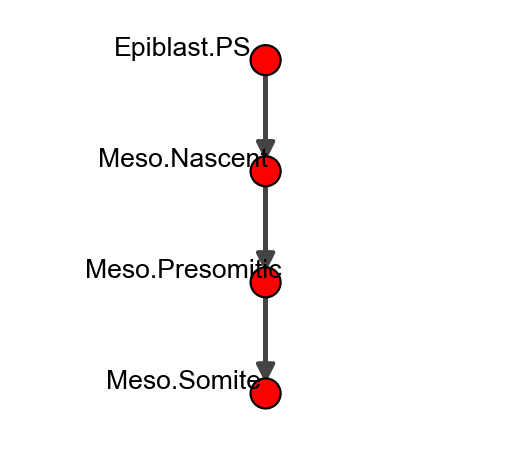

Preparing states and data for GA ...
Starting network reconstruction with GA ...
GRN reconstruction complete.


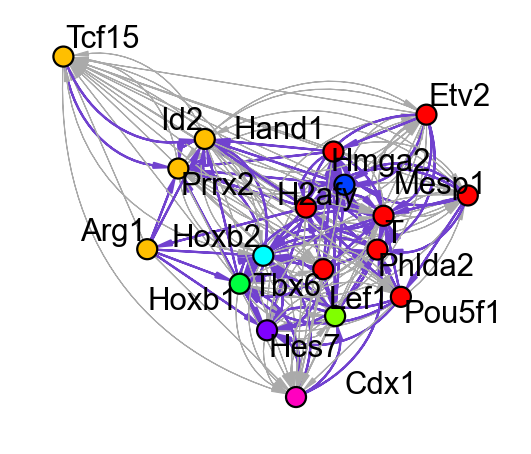

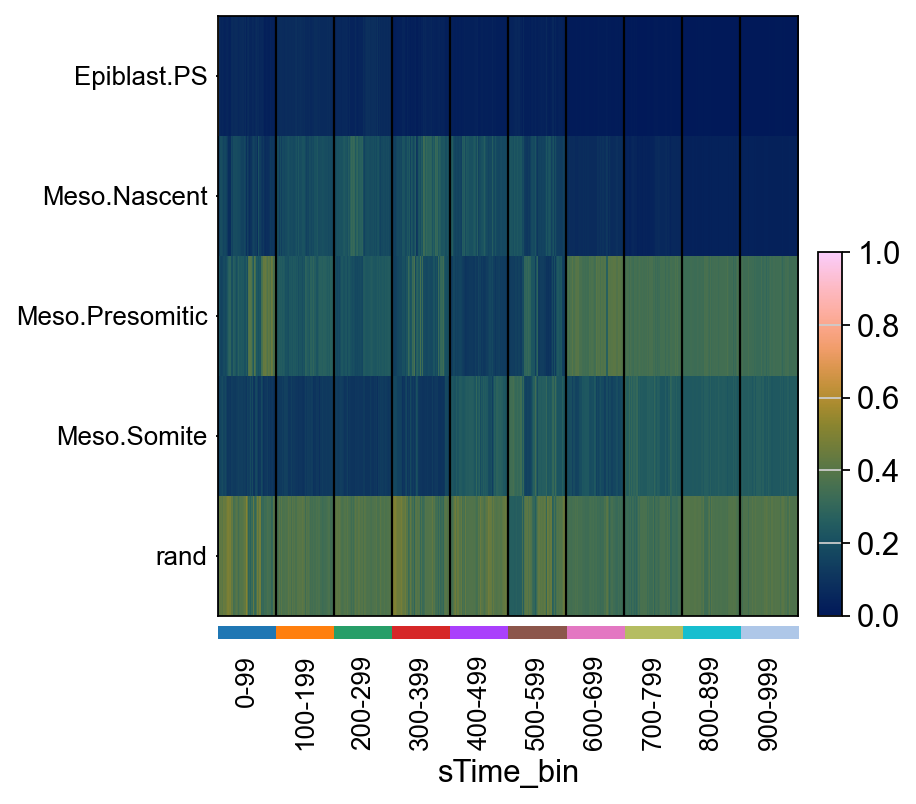

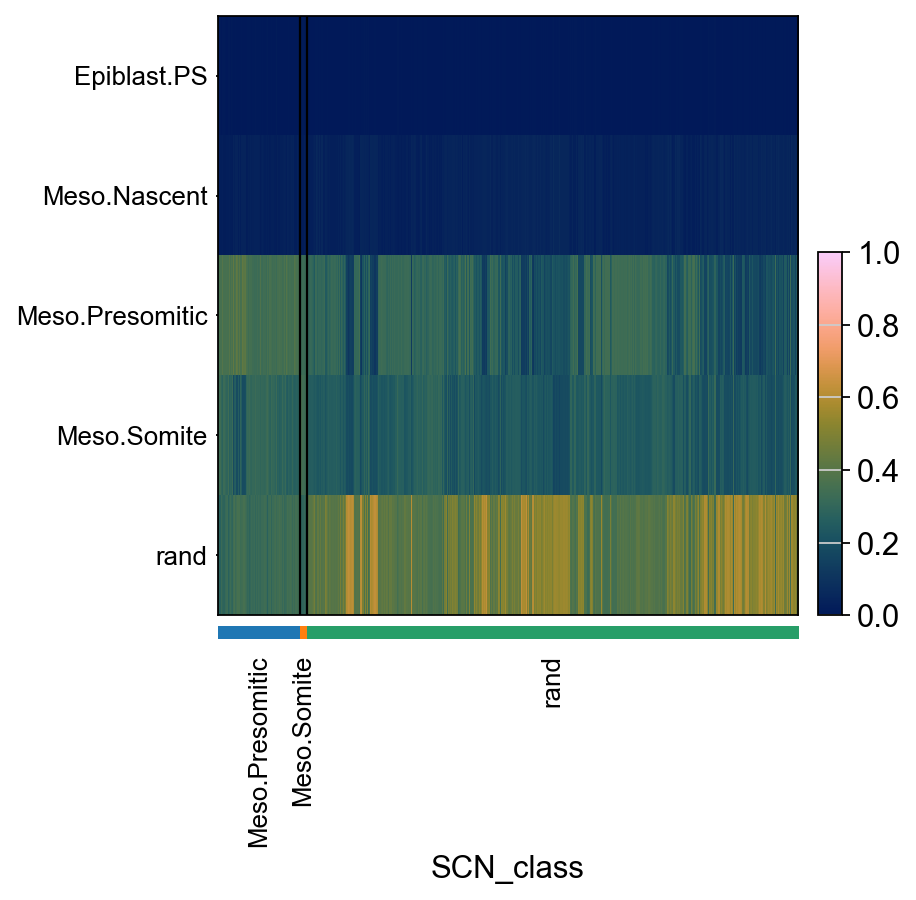

In [17]:
#subset data to TFs only
adEarly_tfs = adEarly[:,adEarly.var.index.isin(intersection)]

# split data
adTrain_rank, adHeldOut_rank = pySCN.splitCommonAnnData(adEarly_tfs, ncells=80,dLevel="celltype")
clf = pySCN.train_rank_classifier(adTrain_rank, dLevel="celltype")

# classify and plot
pySCN.rank_classify(adHeldOut_rank, clf)
pySCN.heatmap_scores(adHeldOut_rank, groupby='SCN_class')

# Manually define the edge list
# this is what i current use
edge_list = [("Epiblast.PS", "Meso.Nascent"), ("Meso.Nascent", "Meso.Presomitic"), ("Meso.Presomitic", "Meso.Somite")]
H = nx.DiGraph(edge_list)
onesc.plot_state_graph(H)

# define the start and end states
start_end_states = {'start': ['Epiblast.PS'], 'end':['Meso.Somite']}
# infer the gene regulatory network
iGRN = onesc.infer_grn(H, start_end_states, adEarly_tfs, num_generations = 20, sol_per_pop = 30, reduce_auto_reg=True, ideal_edges = 0, GA_seed_list = [1, 3], init_pop_seed_list = [21, 25], cluster_col='celltype', pseudoTime_col='ct_pseudotime')
# plot the gene regulatory network
grn_ig = onesc.dataframe_to_igraph(iGRN)
onesc.plot_grn(grn_ig, layout_method='fr',community_first=True)

# get the gene regulatory network
adEarly_epiblasts = adEarly_tfs[adEarly_tfs.obs['celltype'] == 'Epiblast.PS'].copy()
xstates = onesc.define_states_adata(adEarly_epiblasts, min_mean = 0.05, min_percent_cells = 0.20) * 2 

# init the network
netname = 'epiblast_diff'
netsim = onesc.network_structure()
netsim.fit_grn(iGRN)
sim = onesc.OneSC_simulator()
sim.add_network_compilation(netname, netsim)

# simulate the data
simlist_wt = onesc.simulate_parallel_adata(sim, xstates, netname, n_cores = 8, num_sim = 1000, num_runs = 32, t_interval = 0.01, noise_amp = 0.1)

# classify the data
ad_sim1 = simlist_wt[0].copy()
pySCN.rank_classify(ad_sim1, clf)

# a hack because sc.pl.heatmap requires a 'groupby', so groupby simulation time bin
tmp_obs = ad_sim1.obs.copy()
bins = np.linspace(-1, 999, 11)
labels = [f"{int(bins[i]) + 1}-{int(bins[i+1])}" for i in range(len(bins)-1)]

tmp_obs['sTime_bin'] = pd.cut(tmp_obs['sim_time'], bins=bins, labels=labels)
ad_sim1.obs = tmp_obs

# plot the heatmap
pySCN.heatmap_scores(ad_sim1, groupby = 'sTime_bin')

# look at wt 
ad_wt = onesc.sample_and_compile_anndatas(simlist_wt, X=50, time_bin=(80, 100), sequential_order_column='sim_time')
pySCN.rank_classify(ad_wt, clf)
pySCN.heatmap_scores(ad_wt, groupby = 'SCN_class')

In [312]:
# # set the initial and end clusters
# initial_clusters = ['Epiblast.PS']
# end_clusters = ['Meso.Somite']
# # construct the graph based on psuedotime
# state_path = onesc.construct_cluster_graph_adata(adEarly_tfs, initial_clusters = initial_clusters, terminal_clusters = end_clusters, cluster_col = "celltype", pseudo_col = "ct_pseudotime")
# # plot the graph
# onesc.plot_state_graph(state_path)

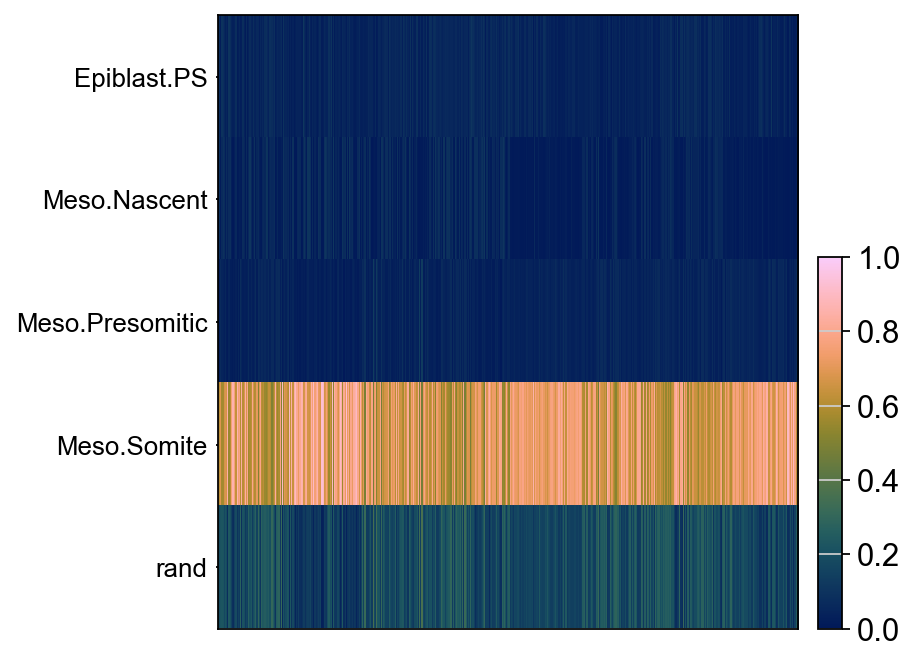

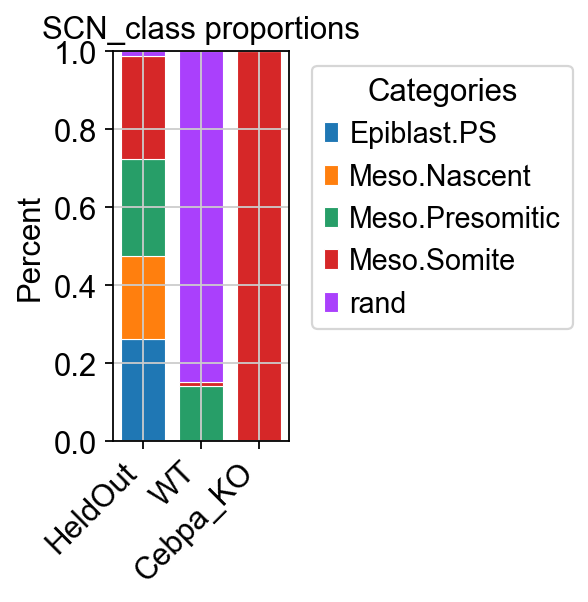

In [18]:
# perturb the data
perturb_dict = dict()
# perturb_dict['Eomes'] = 1
perturb_dict['Mesp2'] = 1

simlist_ko = onesc.simulate_parallel_adata(sim, xstates, 'epiblast_diff', perturb_dict = perturb_dict, n_cores = 8, num_sim = 1000, t_interval = 0.1, noise_amp = 0.5)

# classify the data
ad_ko = onesc.sample_and_compile_anndatas(simlist_ko, X=50, time_bin=(80, 100), sequential_order_column='sim_time')
pySCN.rank_classify(ad_ko, clf)
pySCN.heatmap_scores(ad_ko, groupby = 'SCN_class')

# plot the differences
pySCN.plot_cell_type_proportions([adHeldOut_rank,ad_wt, ad_ko], obs_column = "SCN_class", labels=["HeldOut", "WT","Cebpa_KO"])

# Later data - Mesoderm

In [19]:
# Read in query data
adLate_Mesoderm = sc.read_h5ad("data/adLate_Mesoderm.h5ad")

# get rid of mitochondrial genes and ribosomal genes
adLate_Mesoderm.var['mt'] = adLate_Mesoderm.var_names.str.startswith('MT-')
ribo_prefix = ("RPS","RPL")
adLate_Mesoderm.var['ribo'] = adLate_Mesoderm.var_names.str.startswith(ribo_prefix)
sc.pp.calculate_qc_metrics(adLate_Mesoderm, qc_vars=['mt','ribo'], percent_top=None, log1p=False, inplace=True)

# Now, do the filtering. First, keep only cells with < 20% mitochonrially encoded gene total UMIs
# adLate_Mesoderm = adLate_Mesoderm[adLate_Mesoderm.obs['pct_counts_mt']<20,:].copy()

# # Now filter based on total number of genes detected (at least 500) and total number of counts (less than 30,000). And keep genes that are detected in at least 3 cells.
# sc.pp.filter_cells(adLate_Mesoderm, min_genes=500)
# sc.pp.filter_cells(adLate_Mesoderm, max_counts=30000)
# sc.pp.filter_genes(adLate_Mesoderm, min_cells=3)

# ## Norm, HVG, PCA, kNN
sc.pp.normalize_total(adLate_Mesoderm , target_sum=1e4)
sc.pp.log1p(adLate_Mesoderm)
sc.pp.highly_variable_genes(adLate_Mesoderm , min_mean=0.0125, max_mean=6, min_disp=0.25)
sc.tl.pca(adLate_Mesoderm , use_highly_variable=True)

# # unspervised clustering
n_neighbors = 10
n_pcs = 15
sc.pp.neighbors(adLate_Mesoderm, n_neighbors=n_neighbors, n_pcs=n_pcs)
sc.tl.leiden(adLate_Mesoderm,1)
sc.tl.paga(adLate_Mesoderm)
sc.pl.paga(adLate_Mesoderm, plot=False)
sc.tl.umap(adLate_Mesoderm, 0.1, init_pos='paga')

# # make unique
adLate_Mesoderm.var_names_make_unique()

# Trim the data
# Remove rows with cell types that's less relavent in the early stage of adipocytes development in this dataset
adLate_Mesoderm = adLate_Mesoderm[~adLate_Mesoderm.obs['celltype_update'].isin(["Chondrocytes (Atp1a2+)", 'Chondrocytes (Otor+)', 'Dermomyotome', 'Facial mesenchyme', 'First heart field',
       'Hematoendothelial progenitors','Leydig cells','Muscle progenitor cells','Myoblasts', 'Pre-osteoblasts (Sp7+)', 'Ventricular cardiomyocytes','Lateral plate and intermediate mesoderm'])]
adLate_Mesoderm.obs.celltype_update

4706       Mesodermal progenitors (Tbx6+)
5996       Mesodermal progenitors (Tbx6+)
6764       Mesodermal progenitors (Tbx6+)
12854      Mesodermal progenitors (Tbx6+)
13345      Mesodermal progenitors (Tbx6+)
                        ...              
3342957         Adipocyte cells (Cyp2e1+)
3343187         Adipocyte cells (Cyp2e1+)
3350345                        Sclerotome
3354803        Adipocyte progenitor cells
3364560                       Fibroblasts
Name: celltype_update, Length: 1602, dtype: category
Categories (6, object): ['Adipocyte cells (Cyp2e1+)', 'Adipocyte progenitor cells', 'Brown adipocyte cells', 'Fibroblasts', 'Mesodermal progenitors (Tbx6+)', 'Sclerotome']

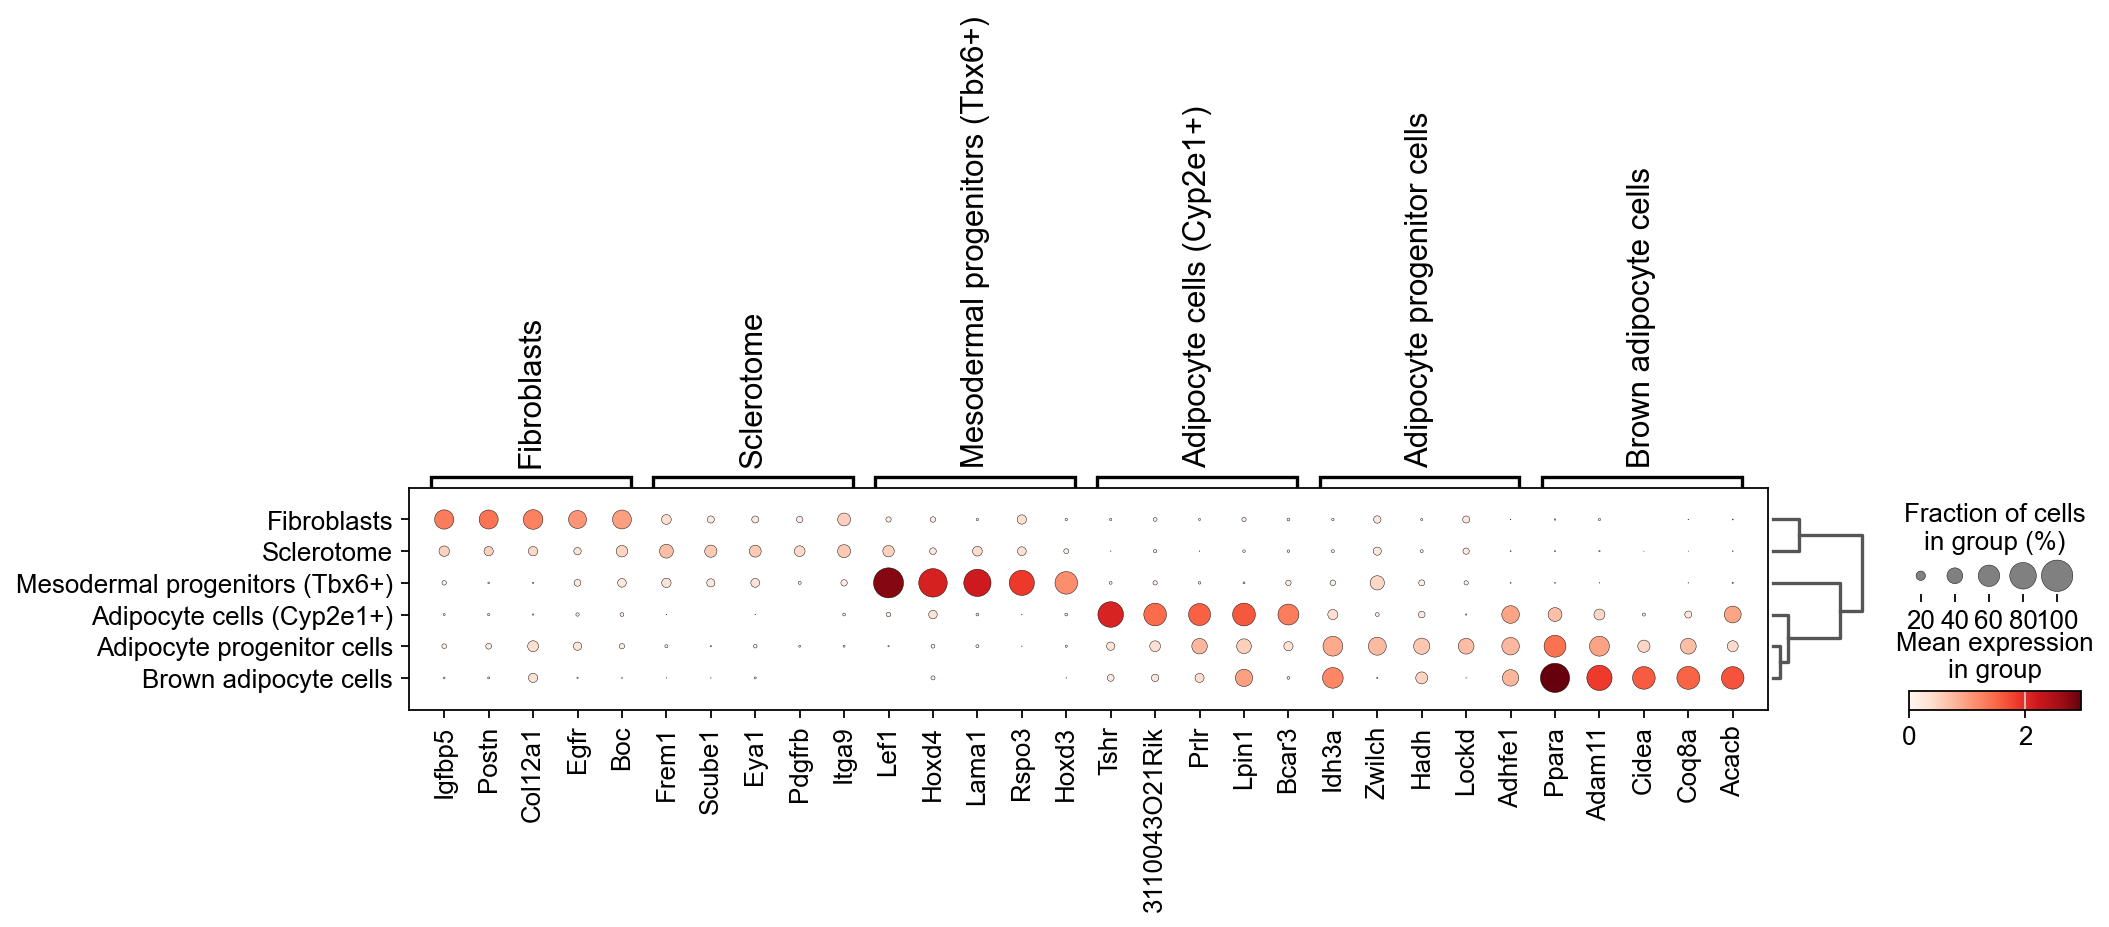

In [20]:
# rank genes
sc.tl.rank_genes_groups(adLate_Mesoderm, use_raw=False, groupby="celltype_update", method="wilcoxon")

# plotting dotplot of top 5 genes for each cell type
sc.tl.filter_rank_genes_groups(adLate_Mesoderm, min_fold_change=.5, min_in_group_fraction=.15, max_out_group_fraction=.15)
sc.pl.rank_genes_groups_dotplot(adLate_Mesoderm, n_genes=5, groupby="celltype_update", dendrogram=True, key='rank_genes_groups_filtered')

In [21]:
# print out the number of cells in each cell type
pd.Series(adLate_Mesoderm.obs['celltype_update']).value_counts()

Fibroblasts                       400
Sclerotome                        400
Adipocyte progenitor cells        201
Mesodermal progenitors (Tbx6+)    201
Adipocyte cells (Cyp2e1+)         200
Brown adipocyte cells             200
Name: celltype_update, dtype: int64

inferring a principal tree --> parameters used 
    7 principal points, sigma = 0.1, lambda = 1, metric = euclidean
    fitting:   0%|          | 0/1000 [00:00<?, ?it/s]
    converged
    finished (0:00:00) --> added 
    .uns['ppt'], dictionnary containing inferred tree.
    .obsm['X_R'] soft assignment of cells to principal points.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['F'] coordinates of principal points in representation space.


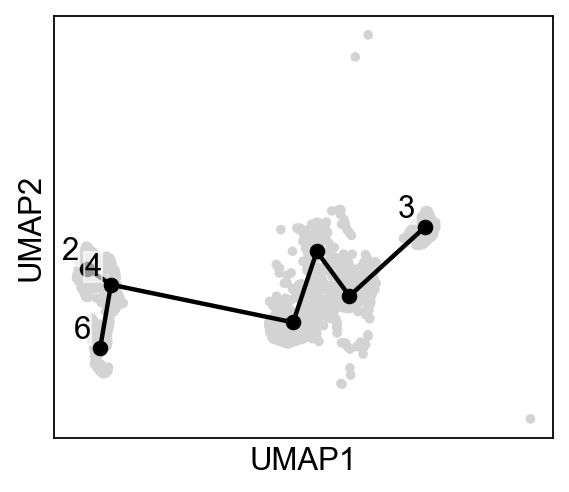

In [22]:
# Tree learning with SimplePPT using palantir embedding
scf.tl.tree(adLate_Mesoderm,method="ppt",Nodes=7,use_rep="umap",
            device="cpu",seed=1,ppt_lambda=1,ppt_sigma=0.1, ppt_nsteps=1000)
# plot
scf.pl.graph(adLate_Mesoderm, basis='umap')

In [23]:
# know that 3 is start
scf.tl.root(adLate_Mesoderm,3)
# get pseudotime
scf.tl.pseudotime(adLate_Mesoderm,n_jobs=20,n_map=1,seed=42)

node 3 selected as a root --> added
    .uns['graph']['root'] selected root.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.
projecting cells onto the principal graph
    finished (0:00:00) --> added
    .obs['edge'] assigned edge.
    .obs['t'] pseudotime value.
    .obs['seg'] segment of the tree assigned.
    .obs['milestones'] milestone assigned.
    .uns['pseudotime_list'] list of cell projection from all mappings.


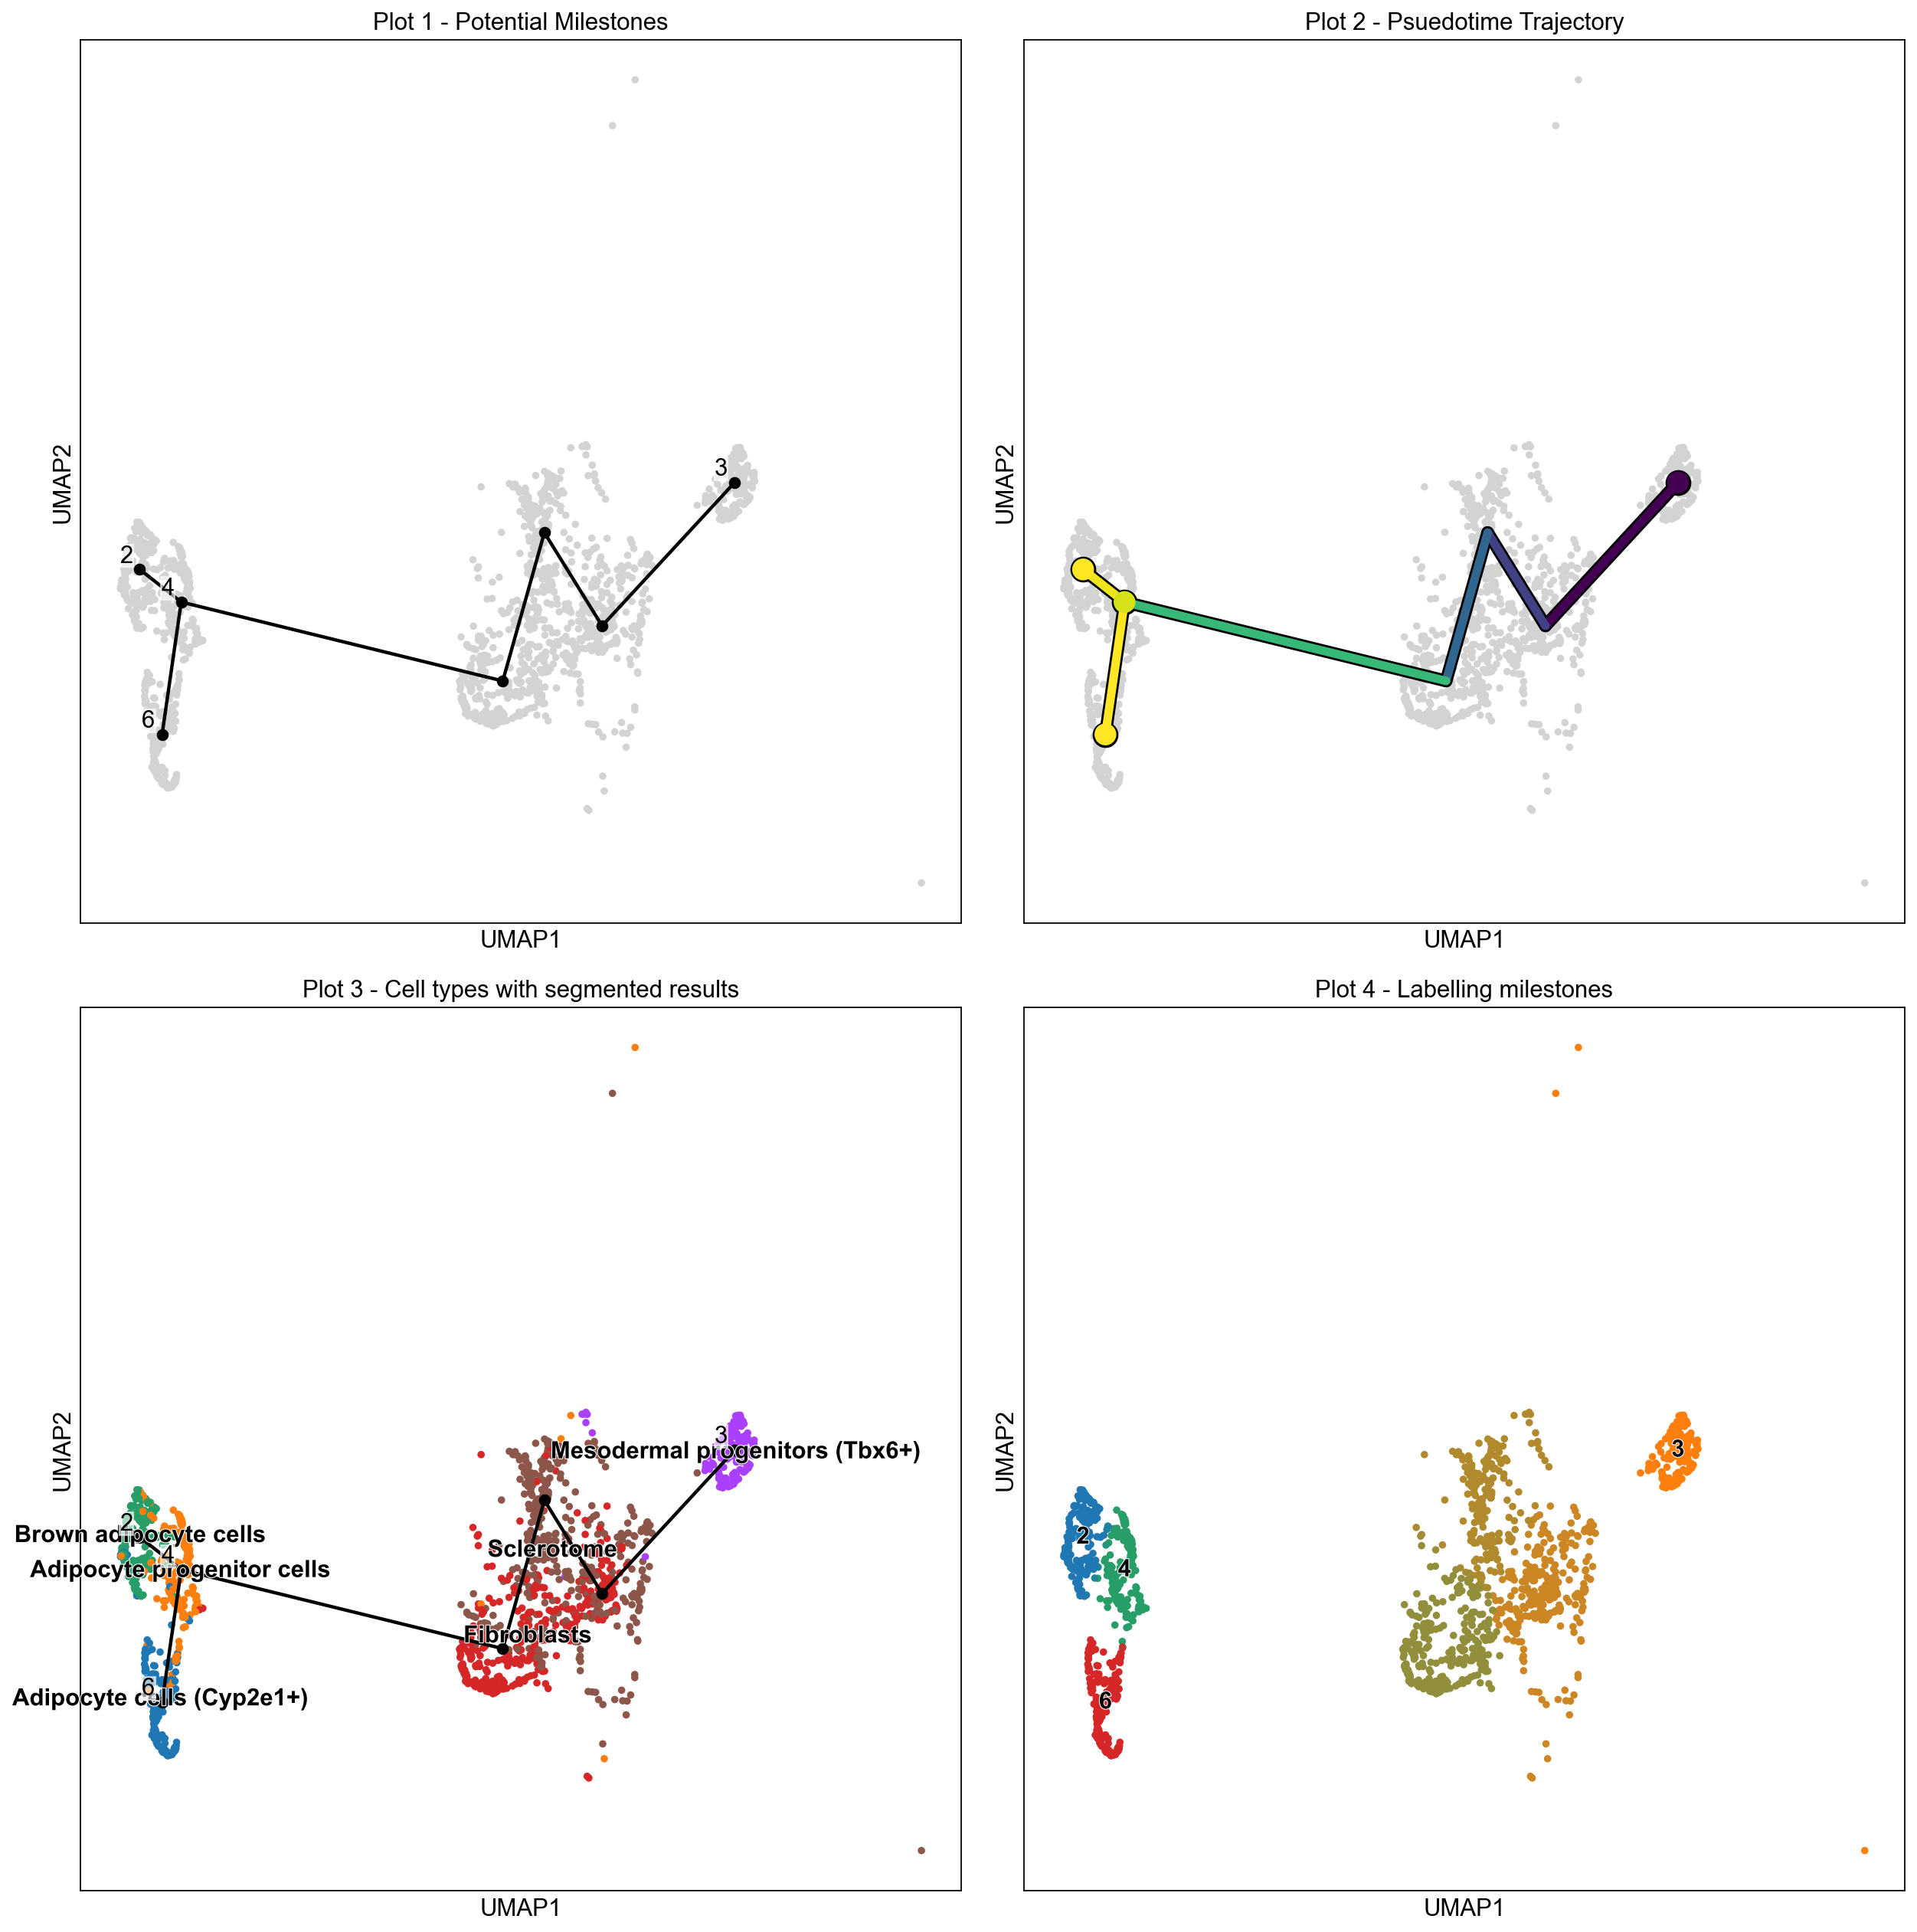

In [24]:
# set the method used for plotting
method_used = "umap"

# graph all required plots
sc.set_figure_params()
fig, axs=plt.subplots(2,2,figsize=(16,16))
axs=axs.ravel()
scf.pl.graph(adLate_Mesoderm,basis=method_used,show=False,ax=axs[0], title = "Plot 1 - Potential Milestones")
scf.pl.trajectory(adLate_Mesoderm,basis=method_used,show=False,ax=axs[1], title = "Plot 2 - Psuedotime Trajectory")
# scf.pl.graph(adLate_Mesoderm,color_cells=["seg"],legend_loc="on data",show=False,ax=axs[2],legend_fontoutline=True, basis=method_used, title = "Plot 3 - Cell types with segmented results")
scf.pl.graph(adLate_Mesoderm,color_cells=["celltype_update"],legend_loc="on data",show=False,ax=axs[2],legend_fontoutline=True, basis=method_used, title = "Plot 3 - Cell types with segmented results")
scf.pl.milestones(adLate_Mesoderm,ax=axs[3],show=False,annotate=True, basis=method_used, title = "Plot 4 - Labelling milestones")
plt.tight_layout()

Generating dendrogram of tree
    segment : 100%|██████████| 3/3 [00:02<00:00,  1.06it/s]
    finished (0:00:02) --> added 
    .obsm['X_dendro'], new embedding generated.
    .uns['dendro_segments'] tree segments used for plotting.


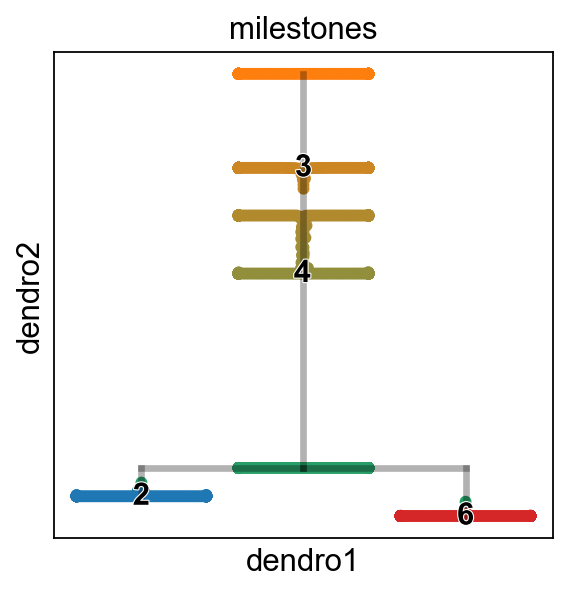

In [25]:
# Generate a single-cell dendrogram embedding.
scf.tl.dendrogram(adLate_Mesoderm)
scf.pl.dendrogram(adLate_Mesoderm,color="milestones",legend_loc="on data",color_milestones=True,legend_fontoutline=True)

test features for association with the trajectory
    single mapping : 100%|██████████| 24552/24552 [00:59<00:00, 411.95it/s]
    found 2917 significant features (0:00:59) --> added
    .var['p_val'] values from statistical test.
    .var['fdr'] corrected values from multiple testing.
    .var['st'] proportion of mapping in which feature is significant.
    .var['A'] amplitue of change of tested feature.
    .var['signi'] feature is significantly changing along pseudotime.
    .uns['stat_assoc_list'] list of fitted features on the graph for all mappings.


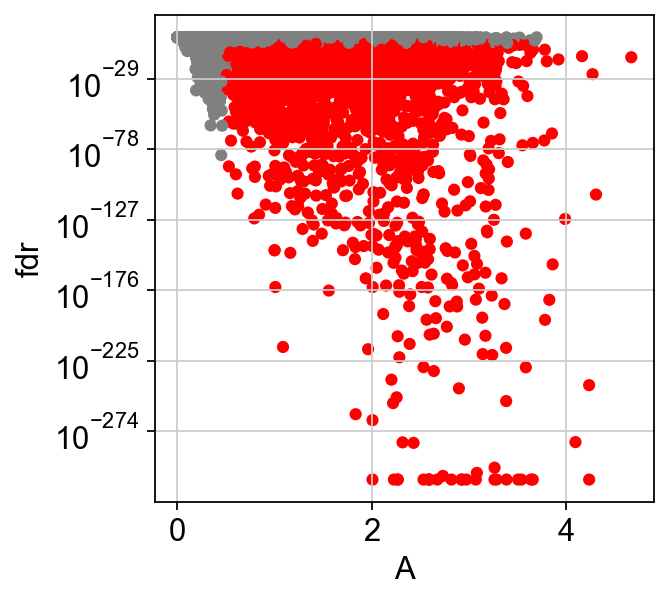

In [26]:
# Determine a set of genes significantly associated with the trajectory.
scf.tl.test_association(adLate_Mesoderm, fdr_cut=0.0001, A_cut=.5, n_jobs=20) # tried to make this lower but it didn't work
# plot
sc.set_figure_params()
scf.pl.test_association(adLate_Mesoderm)

In [27]:
# Model feature expression levels as a function of tree positions.
scf.tl.fit(adLate_Mesoderm,n_jobs=20)

fit features associated with the trajectory
    single mapping : 100%|██████████| 2917/2917 [00:16<00:00, 172.38it/s]
    finished (adata subsetted to keep only fitted features!) (0:00:17) --> added
    .layers['fitted'], fitted features on the trajectory for all mappings.
    .raw, unfiltered data.


Clustering features using fitted layer
    finished (0:00:02) --> added 
    .var['clusters'] identified modules.


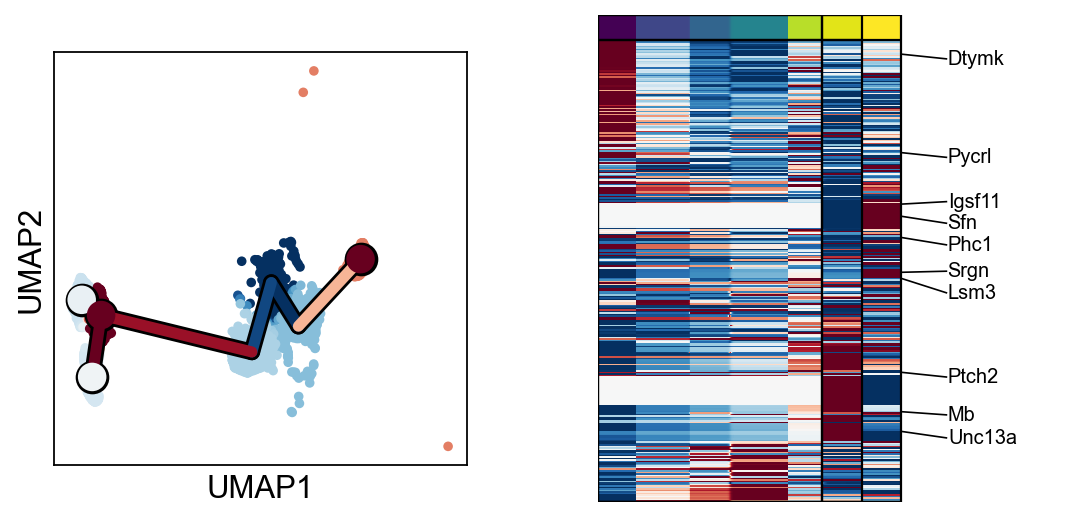

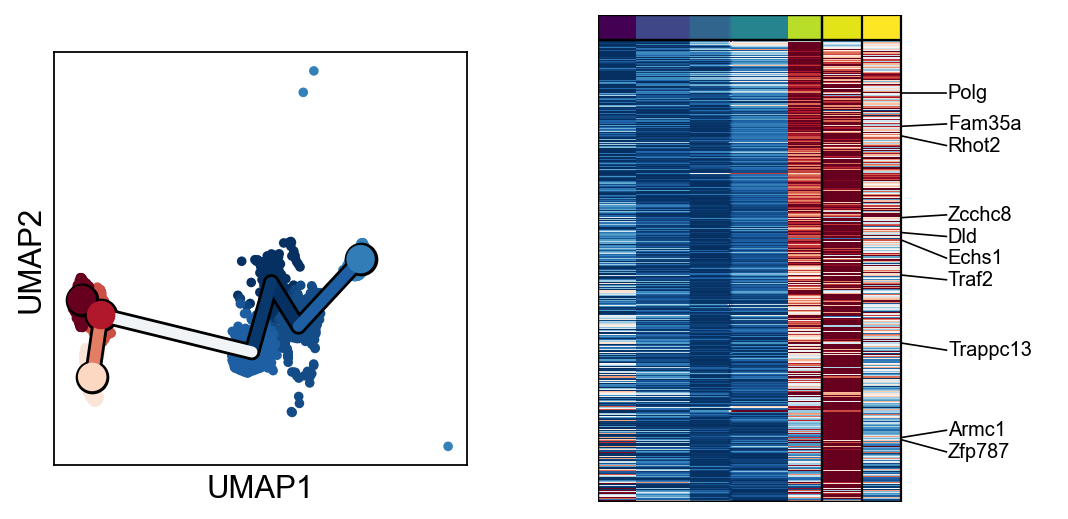

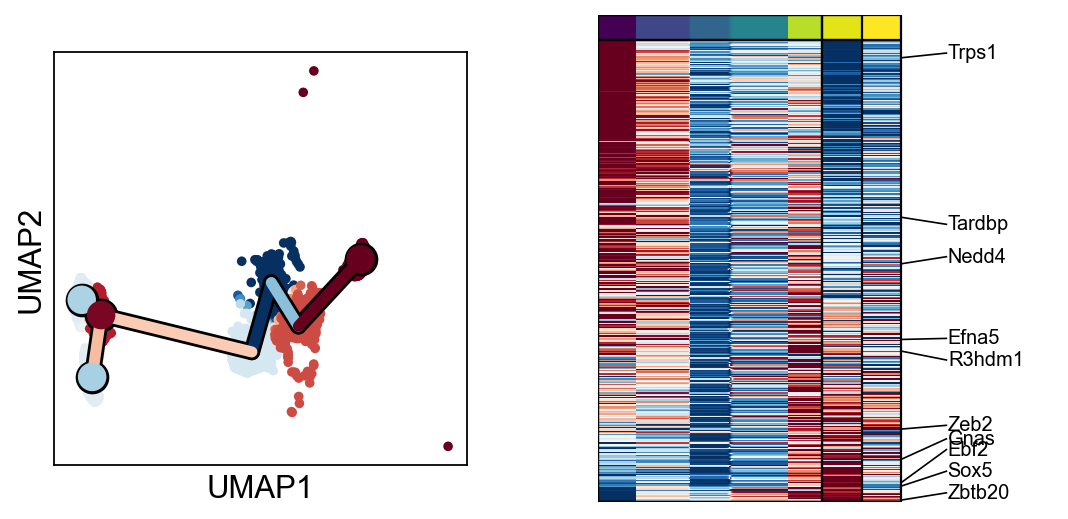

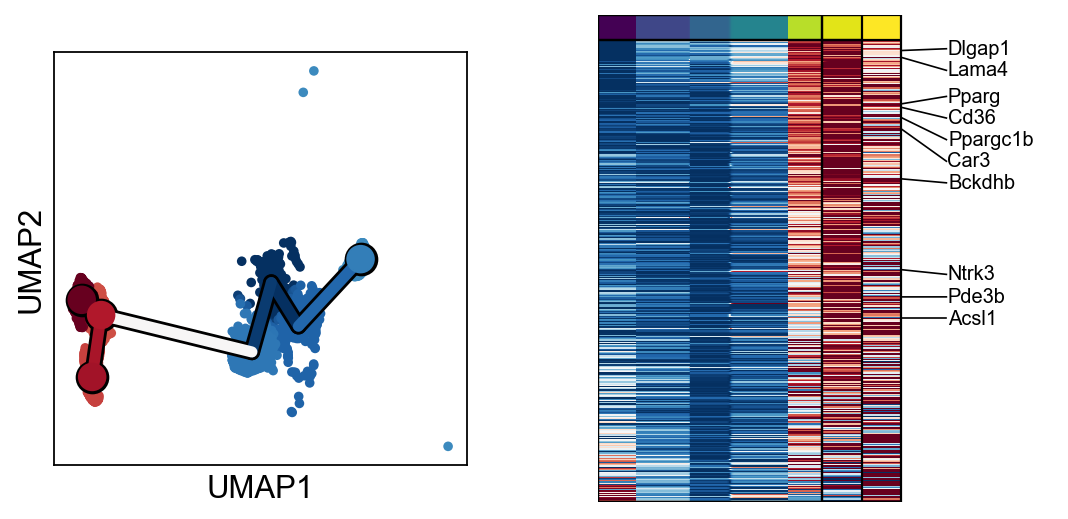

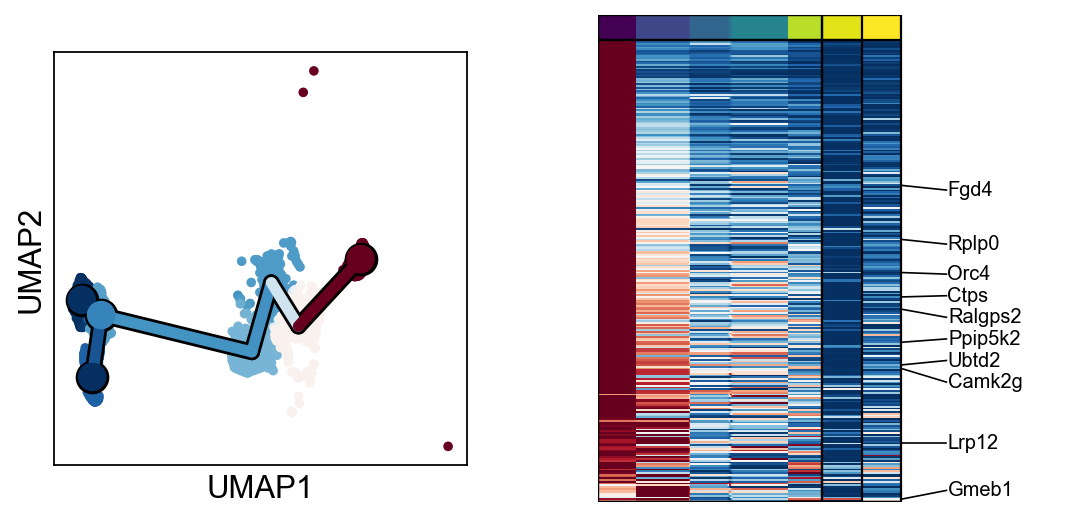

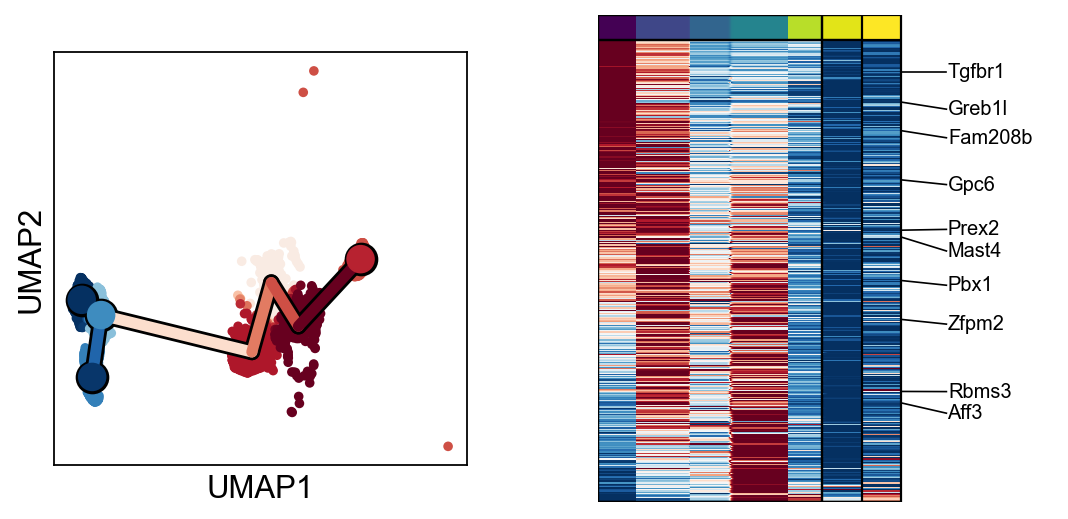

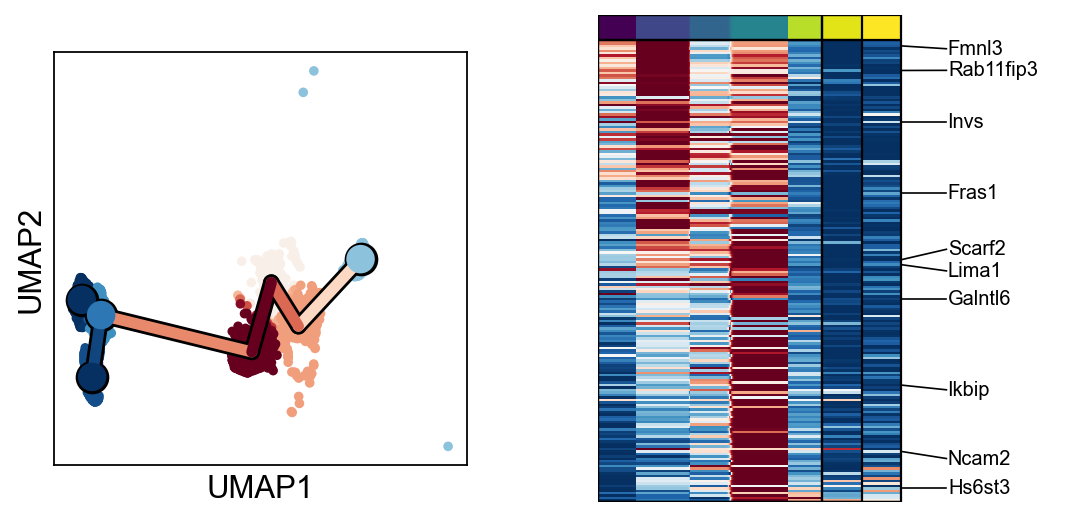

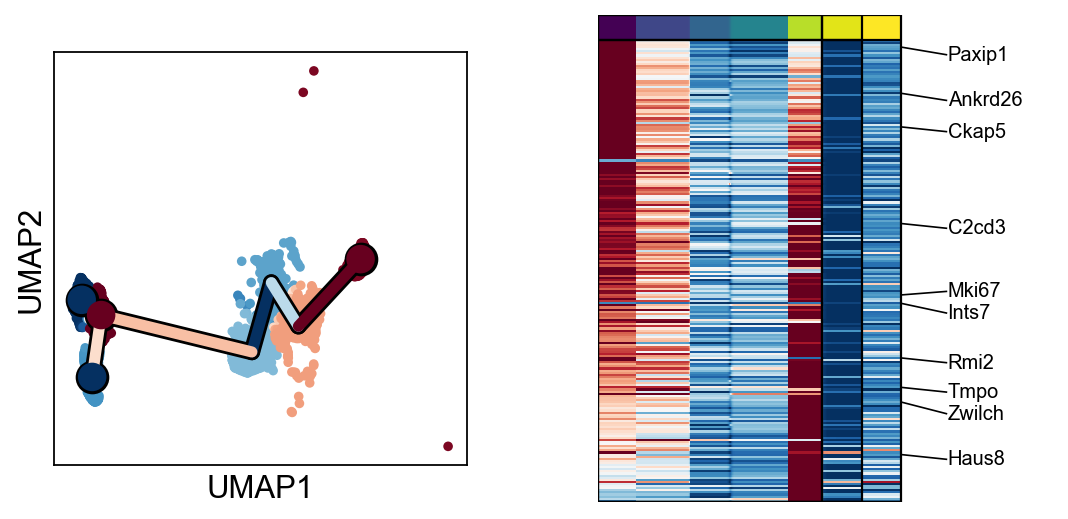

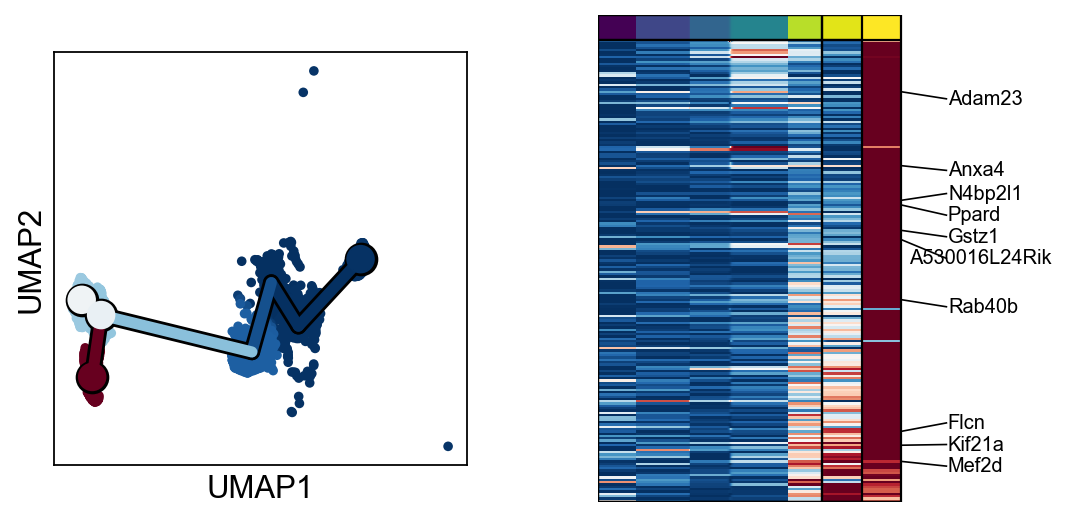

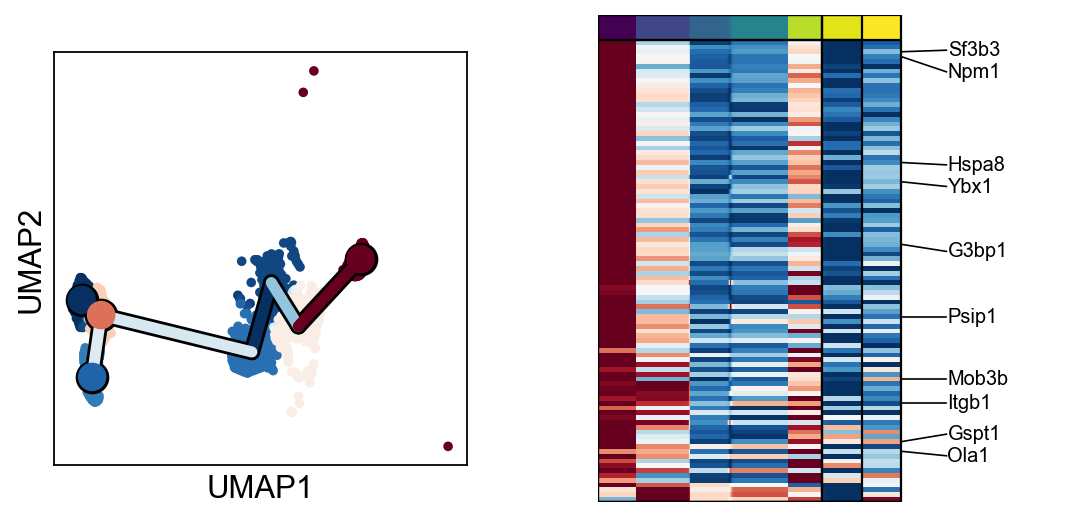

In [28]:
# cluster the data
scf.tl.cluster(adLate_Mesoderm,n_neighbors=20,metric="correlation")
# plot clusters
adLate_Mesoderm.var.clusters.unique()
for c in adLate_Mesoderm.var["clusters"].unique():
    scf.pl.trends(adLate_Mesoderm,features=adLate_Mesoderm.var_names[adLate_Mesoderm.var.clusters==c],basis="umap")

In [29]:
# read in transcription factors
allTFs = pd.read_csv("/Users/calebhallinan/Desktop/jhu/classes/computational_stem_cell_biology/homeworks/hw3/data/allTFs_mm_aertslab_011924.txt", header = None)
# make a list
allTFs = allTFs[0].tolist()

# get intersection
intersection = list(set(allTFs) & set(adLate_Mesoderm.var[adLate_Mesoderm.var["A"] > 3].index.tolist()))
intersection.append("Lef1")
intersection.append("Hmga2")
intersection

# # get only the TFs that are in the intersection
# adLate_Mesoderm.uns[adLate_Mesoderm.var.loc[intersection]]

['Pbx1',
 'Gmeb1',
 'Sox5',
 'Nfib',
 'Ppara',
 'Nfia',
 'Zcchc17',
 'Pparg',
 'Ppard',
 'Zbtb20',
 'Trps1',
 'Ebf1',
 'Zeb2',
 'Thrb',
 'Bcl6',
 'Ebf2',
 'Tcf12',
 'Paxip1',
 'Esrrg',
 'Zfp787',
 'Lef1',
 'Hmga2']

In [30]:
# check if a gene is in the list
name = "Hmga2"
if name in allTFs:
    print("The name is in the list.")
else:
    print("The name is not in the list.")


The name is in the list.


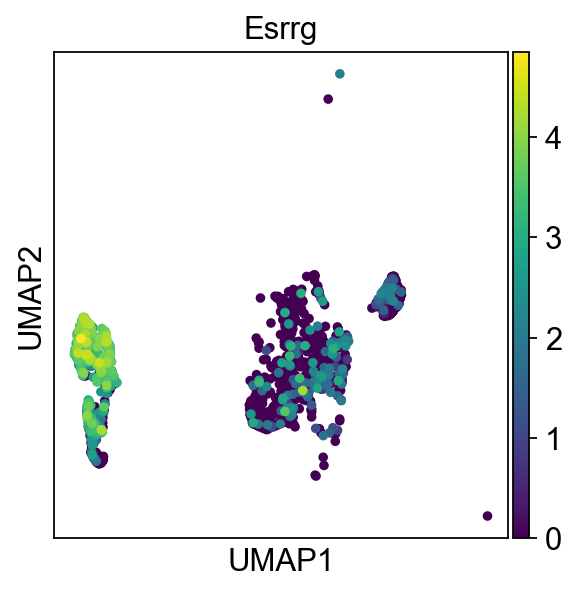

In [31]:
# plot gene Sulf1 on the umap
sc.pl.umap(adLate_Mesoderm, color = ['Esrrg'], cmap = "viridis")

Computing CytoTRACE score with `2917` genes. Consider using more than `10000` genes
Adding `adata.obs['ct_score']`
       `adata.obs['ct_pseudotime']`
       `adata.obs['ct_num_exp_genes']`
       `adata.var['ct_gene_corr']`
       `adata.var['ct_correlates']`
       `adata.uns['ct_params']`
    Finish (0:00:00)


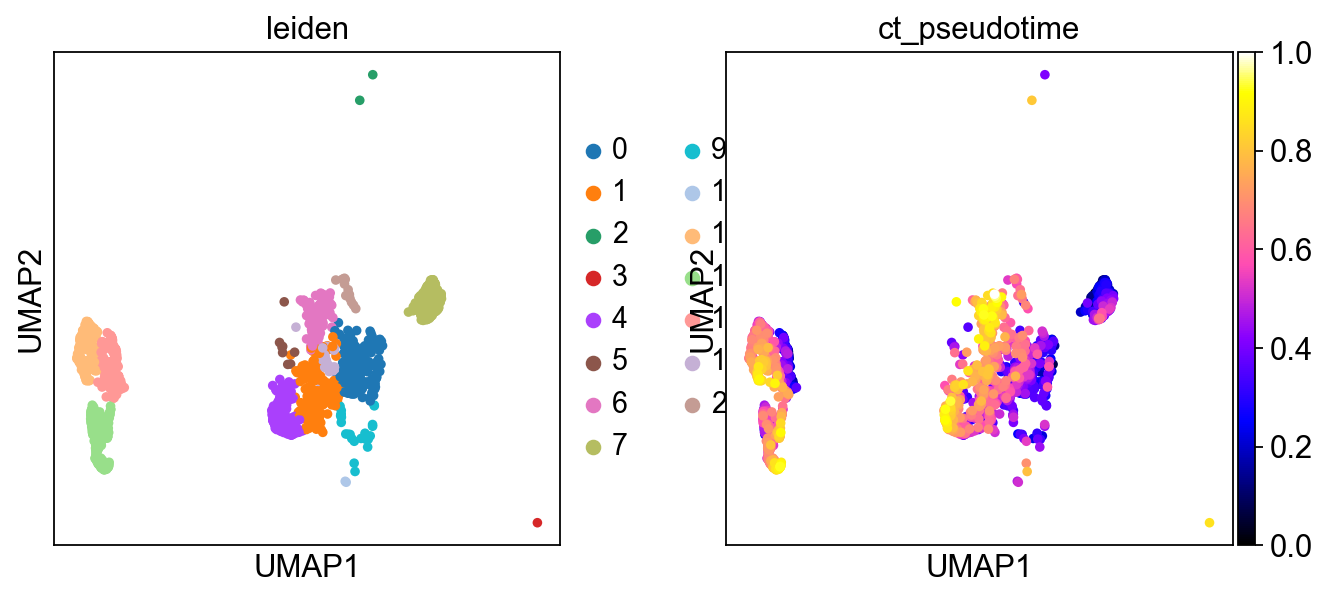

In [32]:
# verbose
cr.settings.verbosity = 2

# calculate pseudotime
ctk = CytoTRACEKernel(adLate_Mesoderm).compute_cytotrace(layer = "X", n_genes=1000)

# plot pseudotime
sc.pl.embedding(
    adLate_Mesoderm,
    color=["leiden", "ct_pseudotime"],
    basis="umap",
    color_map="gnuplot2"
)

In [33]:
#subet 
adLate_Mesoderm_tfs = adLate_Mesoderm[:,adLate_Mesoderm.var.index.isin(intersection)]

adTrain_rank, adHeldOut_rank = pySCN.splitCommonAnnData(adLate_Mesoderm_tfs, ncells=50,dLevel="celltype_update")
clf = pySCN.train_rank_classifier(adTrain_rank, dLevel="celltype_update")

Brown adipocyte cells : 
200
Mesodermal progenitors (Tbx6+) : 
201
Fibroblasts : 
400
Adipocyte cells (Cyp2e1+) : 
200
Sclerotome : 
400
Adipocyte progenitor cells : 
201


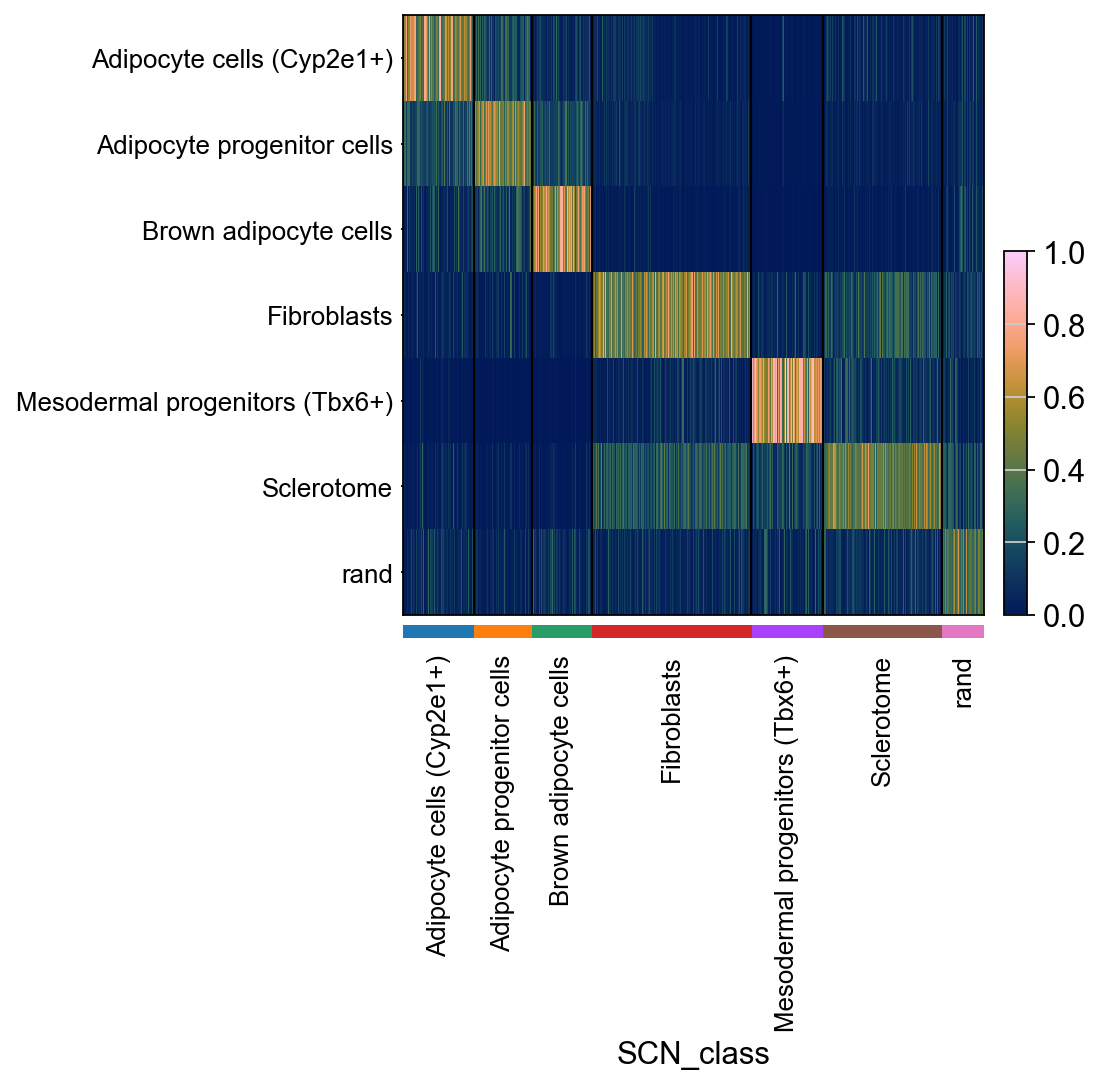

In [34]:
pySCN.rank_classify(adHeldOut_rank, clf)
pySCN.heatmap_scores(adHeldOut_rank, groupby='SCN_class')

Error: Failed to construct the cluster/cell state network. Make sure the initial cell state has the lowest average pseuodtime and terminal cell state has the highest average pseudotime. 


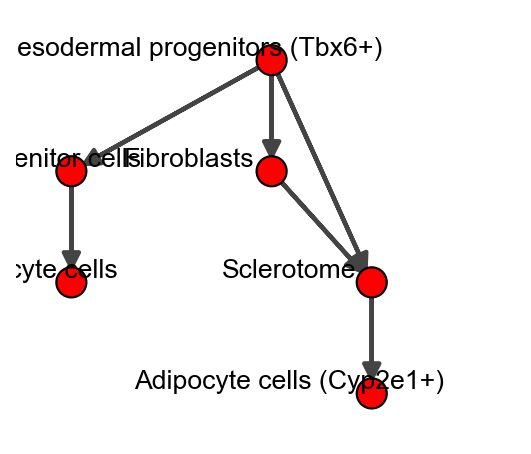

Preparing states and data for GA ...
Zeb2 have conflicting states, the below states are deleted
['Mesodermal progenitors (Tbx6+)_stable_trajectory_0', 'Mesodermal progenitors (Tbx6+)_unstable_trajectory_1']
Starting network reconstruction with GA ...
GRN reconstruction complete.


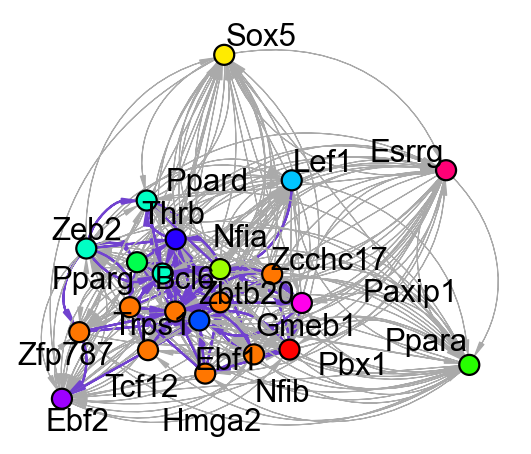

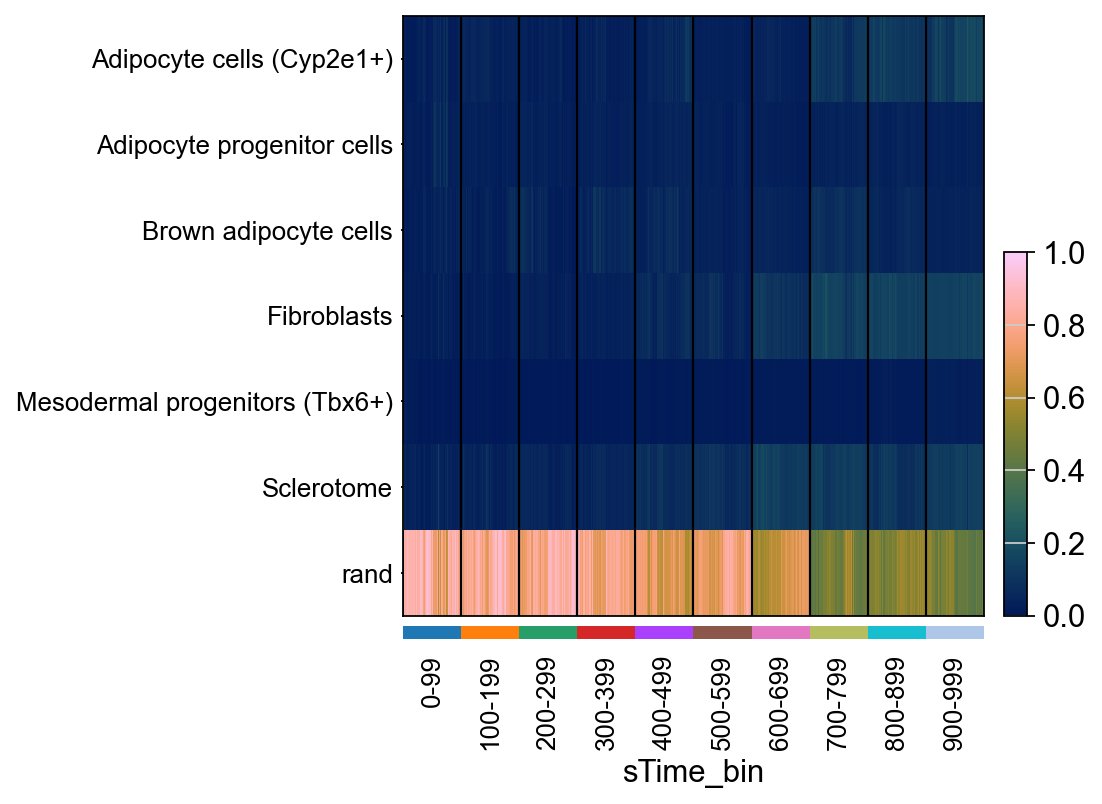

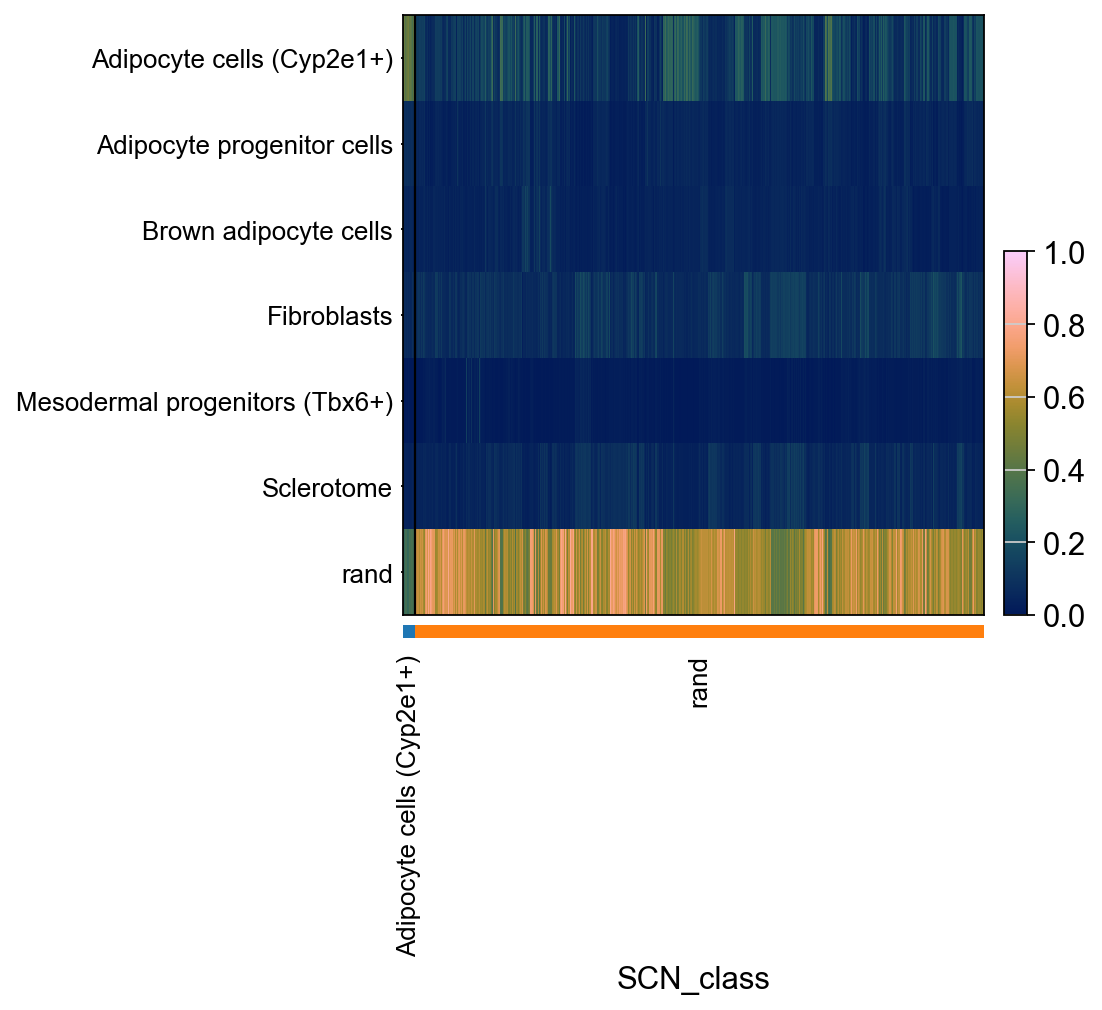

In [35]:
initial_clusters = ['Mesodermal progenitors (Tbx6+)']
end_clusters = ['Adipocyte cells (Cyp2e1+)']
# construct the graph based on psuedotime
state_path = onesc.construct_cluster_graph_adata(adLate_Mesoderm_tfs, initial_clusters = initial_clusters, terminal_clusters = end_clusters, cluster_col = "celltype_update", pseudo_col = "ct_pseudotime")
# plot
onesc.plot_state_graph(state_path)
# define the start and end states
start_end_states = {'start': ['Mesodermal progenitors (Tbx6+)'], 'end':['Adipocyte cells (Cyp2e1+)']}
# infer the gene regulatory network
iGRN = onesc.infer_grn(state_path, start_end_states, adLate_Mesoderm_tfs, num_generations = 20, sol_per_pop = 30, reduce_auto_reg=True, ideal_edges = 0, GA_seed_list = [1, 3], init_pop_seed_list = [21, 25], cluster_col='celltype_update', pseudoTime_col='ct_pseudotime')
# plot the gene regulatory network
grn_ig = onesc.dataframe_to_igraph(iGRN)
onesc.plot_grn(grn_ig, layout_method='fr',community_first=True)
# get the gene regulatory network
adLate_Mesoderm_progenitors = adLate_Mesoderm_tfs[adLate_Mesoderm_tfs.obs['celltype_update'] == 'Mesodermal progenitors (Tbx6+)'].copy()
xstates = onesc.define_states_adata(adLate_Mesoderm_progenitors, min_mean = 0.05, min_percent_cells = 0.20) * 2 
# init
netname = 'mesodermal_progenitors_diff'
netsim = onesc.network_structure()
netsim.fit_grn(iGRN)
sim = onesc.OneSC_simulator()
sim.add_network_compilation(netname, netsim)
# simulate
simlist_wt = onesc.simulate_parallel_adata(sim, xstates, netname, n_cores = 8, num_sim = 1000, num_runs = 32, t_interval = 0.01, noise_amp = 0.1)
# classify
ad_sim1 = simlist_wt[0].copy()
pySCN.rank_classify(ad_sim1, clf)

# a hack because sc.pl.heatmap requires a 'groupby', so groupby simulation time bin
tmp_obs = ad_sim1.obs.copy()
bins = np.linspace(-1, 999, 11)
labels = [f"{int(bins[i]) + 1}-{int(bins[i+1])}" for i in range(len(bins)-1)]
# bins
tmp_obs['sTime_bin'] = pd.cut(tmp_obs['sim_time'], bins=bins, labels=labels)
ad_sim1.obs = tmp_obs
# plot heatmap
pySCN.heatmap_scores(ad_sim1, groupby = 'sTime_bin')
# look at wt
ad_wt = onesc.sample_and_compile_anndatas(simlist_wt, X=50, time_bin=(80, 100), sequential_order_column='sim_time')
pySCN.rank_classify(ad_wt, clf)
pySCN.heatmap_scores(ad_wt, groupby = 'SCN_class')

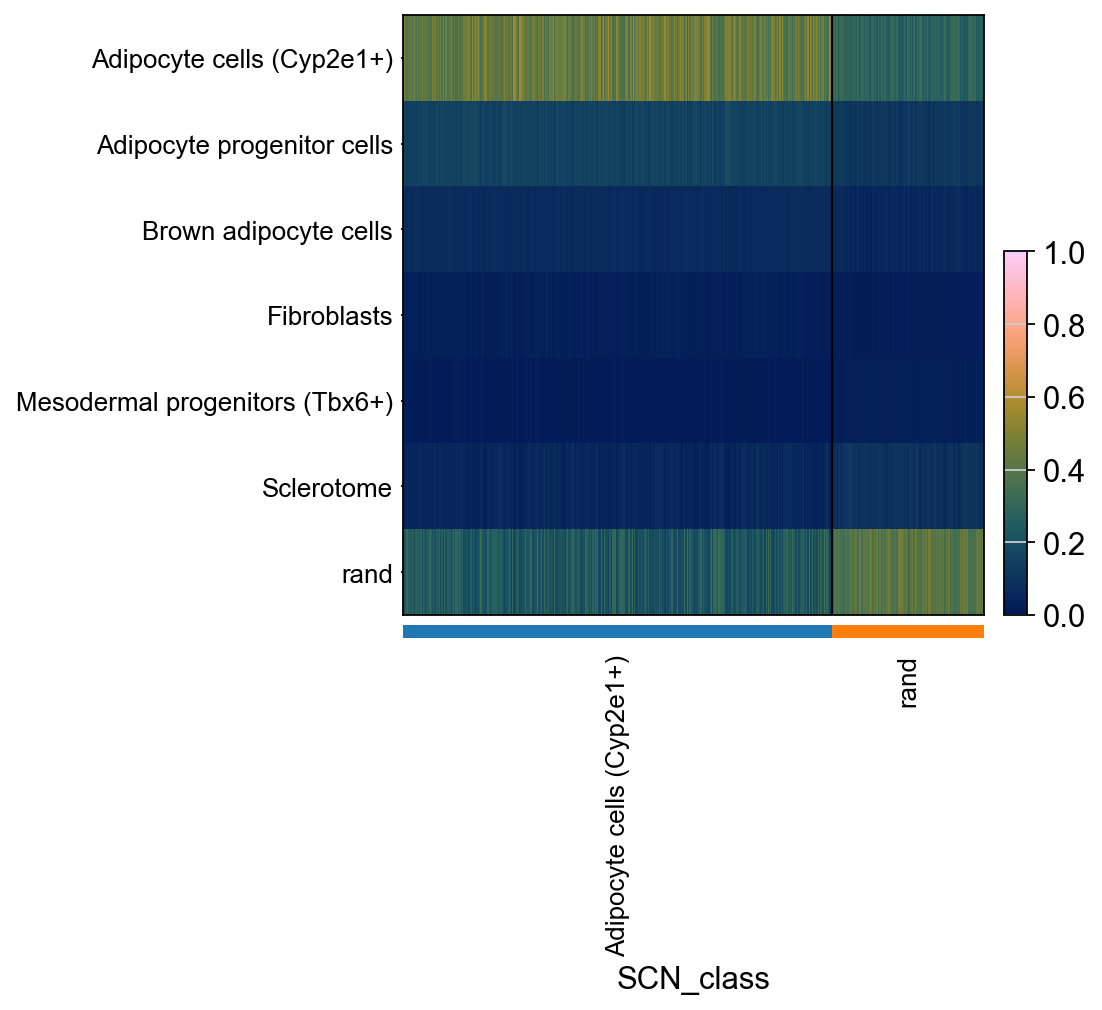

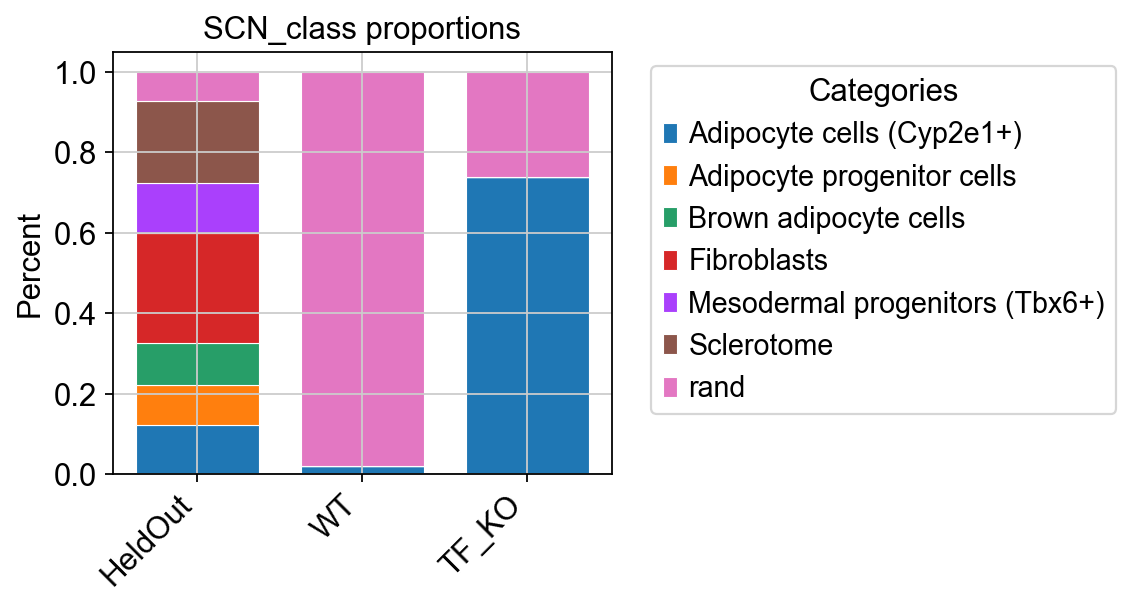

In [38]:
# perturb
perturb_dict = dict()
perturb_dict['Ebf2'] = -1
simlist_cebpa_ko = onesc.simulate_parallel_adata(sim, xstates, 'mesodermal_progenitors_diff', perturb_dict = perturb_dict, n_cores = 8, num_sim = 1000, t_interval = 0.1, noise_amp = 0.5)
# classify
ad_cebpa_ko = onesc.sample_and_compile_anndatas(simlist_cebpa_ko, X=50, time_bin=(80, 100), sequential_order_column='sim_time')
pySCN.rank_classify(ad_cebpa_ko, clf)
pySCN.heatmap_scores(ad_cebpa_ko, groupby = 'SCN_class')
# print the differences
pySCN.plot_cell_type_proportions([adHeldOut_rank,ad_wt, ad_cebpa_ko], obs_column = "SCN_class", labels=["HeldOut", "WT","TF_KO"])